# Recommender Engine after embeddings of user and item


In [1]:
import os
import copy
import datetime
import warnings

import random
from datetime import datetime
import re

import numpy as np
from scipy.stats import t
import pandas as pd
import keras

from matplotlib import pyplot as plt
import matplotlib as mpl

from wordcloud import WordCloud

import seaborn as sns


Using TensorFlow backend.


In [2]:
np.random.seed(42)

pd.set_option('display.max_columns', 100, 'display.width', 1024)
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

mpl.rcParams['axes.facecolor'] = '#12162f'
plt.grid(False)
plt.close()

DATA_PATH = '../input/'
SPLIT_DATE = '2019-01-01'

In [3]:
answers = pd.read_csv(os.path.join(DATA_PATH, 'answers.csv'))
answer_scores = pd.read_csv(os.path.join(DATA_PATH, 'answer_scores.csv'))
comments = pd.read_csv(os.path.join(DATA_PATH, 'comments.csv'))
emails = pd.read_csv(os.path.join(DATA_PATH, 'emails.csv'))
groups = pd.read_csv(os.path.join(DATA_PATH, 'groups.csv'))
group_memberships = pd.read_csv(os.path.join(DATA_PATH, 'group_memberships.csv'))
matches = pd.read_csv(os.path.join(DATA_PATH, 'matches.csv'))
professionals = pd.read_csv(os.path.join(DATA_PATH, 'professionals.csv'))
questions = pd.read_csv(os.path.join(DATA_PATH, 'questions.csv'))
question_scores = pd.read_csv(os.path.join(DATA_PATH, 'question_scores.csv')) 
school_memberships = pd.read_csv(os.path.join(DATA_PATH, 'school_memberships.csv'))
students = pd.read_csv(os.path.join(DATA_PATH, 'students.csv'))
tags = pd.read_csv(os.path.join(DATA_PATH, 'tags.csv'))
tag_questions = pd.read_csv(os.path.join(DATA_PATH, 'tag_questions.csv'))
tag_users = pd.read_csv(os.path.join(DATA_PATH, 'tag_users.csv'))

In [4]:
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)
comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'], infer_datetime_format=True)
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'], infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'], infer_datetime_format=True)

In [5]:
temp = answers.groupby('answers_author_id')['answers_date_added'].max()
professionals['date_last_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']

temp = answers.groupby('answers_author_id')['answers_date_added'].min()
professionals['date_first_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']

temp = comments.groupby('comments_author_id')['comments_date_added'].max()
professionals['date_last_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
professionals['date_first_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']

professionals['date_last_activity'] = professionals[['date_last_answer', 'date_last_comment']].max(axis=1)

professionals['date_first_activity'] = professionals[['date_first_answer', 'date_first_comment']].min(axis=1)

temp = questions.groupby('questions_author_id')['questions_date_added'].max()
students['date_last_question'] = pd.merge(students, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']
temp = questions.groupby('questions_author_id')['questions_date_added'].min()
students['date_first_question'] = pd.merge(students, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
students['date_last_comment'] = pd.merge(students, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']

temp = comments.groupby('comments_author_id')['comments_date_added'].min()
students['date_first_comment'] = pd.merge(students, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']

students['date_last_activity'] = students[['date_last_question', 'date_last_comment']].max(axis=1)
students['date_first_activity'] = students[['date_first_question', 'date_first_comment']].min(axis=1)


In [6]:
pro_emails = pd.merge(professionals, emails, how='inner', left_on='professionals_id', right_on='emails_recipient_id')
pro_emails = pro_emails[pro_emails['emails_frequency_level'] == 'email_notification_immediate']
pro_emails = pro_emails[['professionals_id', 'emails_id', 'emails_date_sent']]

pro_email_ques = pro_emails.merge(matches, left_on='emails_id', right_on='matches_email_id')
pro_email_ques = pro_email_ques.drop(columns=['emails_id', 'matches_email_id']) \
                 .set_index('professionals_id').rename(columns={'matches_question_id': 'questions_id'})

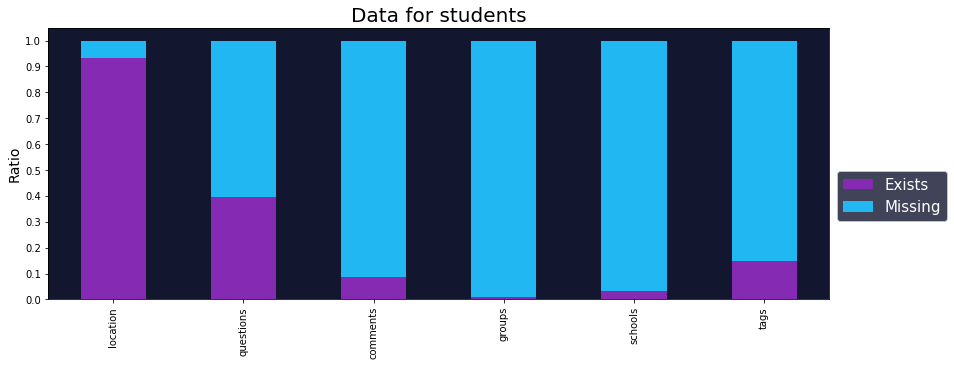

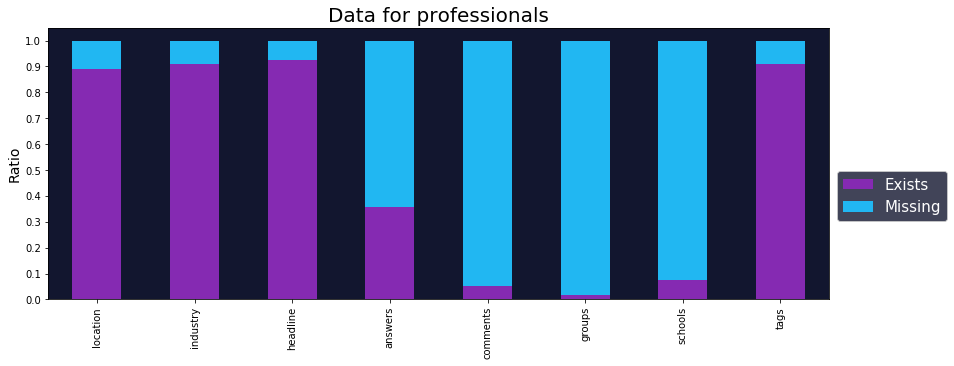

In [7]:
exists = 'Exists'
miss = 'Missing'

fields = {
    'students': {
        'df': students,
        'features': ['location'],
        'count': {
            'questions': questions,
            'comments': comments
        },
        'memberships': {
            'groups': group_memberships,
            'schools': school_memberships
        },
        'plts': {}
    },
    'professionals': {
        'df': professionals,
        'features': ['location', 'industry', 'headline'],
        'count': {
            'answers': answers,
            'comments': comments
        },
        'memberships': {
            'groups': group_memberships,
            'schools': school_memberships
        },
        'plts': {} 
    }
}

for user in fields.keys():
    user_spec = fields[user]
    
    df = user_spec['df']
    
    tmp = df[['{}_{}'.format(user, feature) for feature in user_spec['features']]]
    tmp = tmp.fillna(miss)
    tmp[tmp != miss] = exists 

    for feature in user_spec['features']:
        user_spec['plts'][feature] = tmp.groupby('{}_{}'.format(user, feature)).size()/len(tmp)

    for key, cdf in user_spec['count'].items():
        tf = cdf.groupby('{}_author_id'.format(key)).size()
        tf['counts'] = pd.merge(df, pd.DataFrame(tf.rename('count')), left_on='{}_id'.format(user), right_index=True, how='left')['count'].fillna(0).astype(int)
        
        tf = tf['counts']
        tf[tf > 0] = exists
        tf[tf != exists] = miss
        
        user_spec['plts'][key] = tf.groupby(tf.values).size()/len(tf)

    for key, mdf in user_spec['memberships'].items():
        unique_userid_with_membership = mdf['{}_memberships_user_id'.format(key[:-1])].unique()
        tf = pd.DataFrame()
        tf['val'] = df['{}_id'.format(user)]
        
        tf[tf['val'].isin(unique_userid_with_membership)] = exists
        tf[tf['val'] != exists] = miss

        user_spec['plts'][key] = tf.groupby('val').size()/len(tf)

    unique_user_ids_with_tags = tag_users['tag_users_user_id'].unique()
    tf = pd.DataFrame()
    tf['val'] = df['{}_id'.format(user)]
    
    tf[tf['val'].isin(unique_user_ids_with_tags)] = exists
    tf[tf['val'] != exists] = miss
    
    user_spec['plts']['tags'] = tf.groupby('val').size()/len(tf)
    plt_data = pd.DataFrame(user_spec['plts'])
    
    plt_data.T.plot(kind='bar', stacked=True, figsize=(14, 5), colors=('#852ab2', '#21b7f2'))
    plt.ylabel('Ratio', fontsize=14)
    plt.title('Data for {}'.format(user), fontsize=20)
    plt.yticks(np.arange(0, 1.05, 0.1))
    leg = plt.legend(bbox_to_anchor=(1, 0.5), fontsize=15)
    for text in leg.get_texts():
        plt.setp(text, color = 'w')
    plt.show()

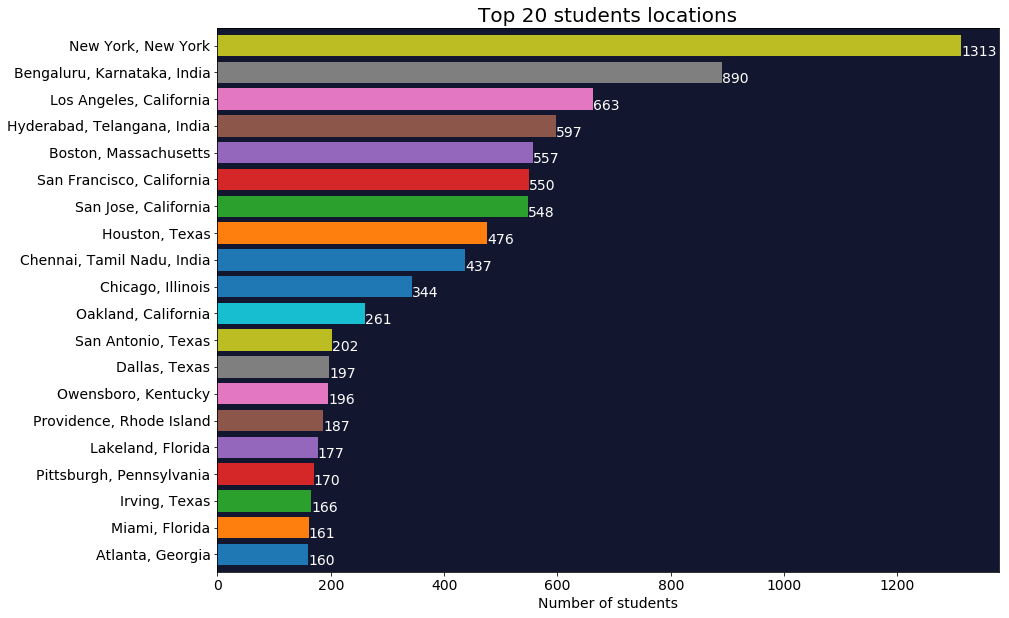

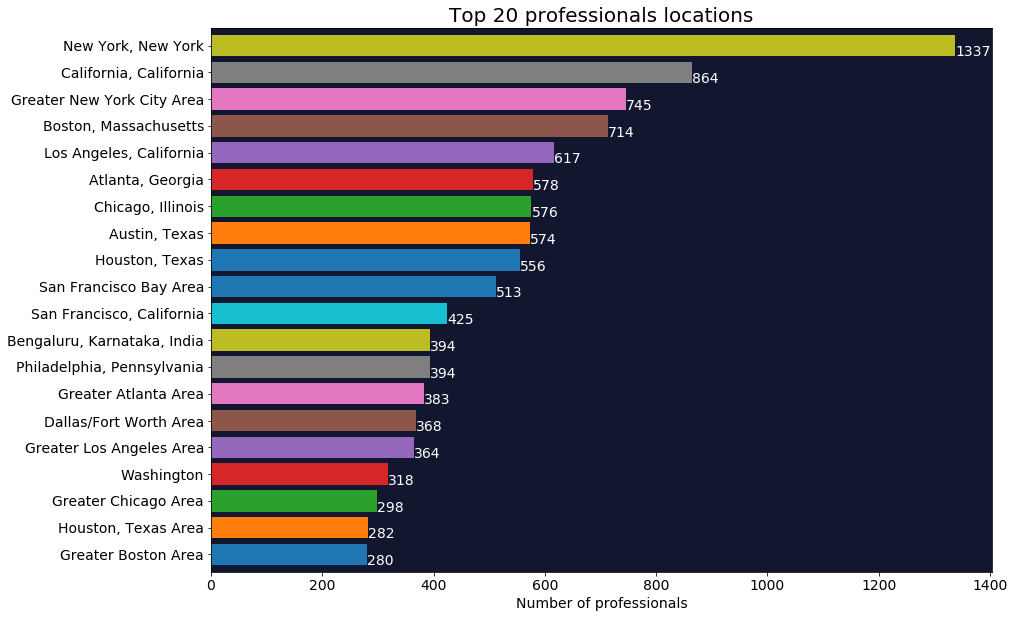

In [8]:
n_locations = 20

users = [
    ('students', students),
    ('professionals', professionals)
]

for user, df in users:
    locations = df['{}_location'.format(user)].value_counts().sort_values(ascending=True).tail(n_locations)
    
    ax = locations.plot(kind='barh',figsize=(14, 10),width=0.8, fontsize=14) 
    ax.set_title('Top %s {} locations'.format(user) % n_locations, fontsize=20)
    ax.set_xlabel('Number of {}'.format(user), fontsize=14)
    for p in ax.patches:
        ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()), color='w', fontsize=14)
    plt.show()
    

### Users Growth Dynamics


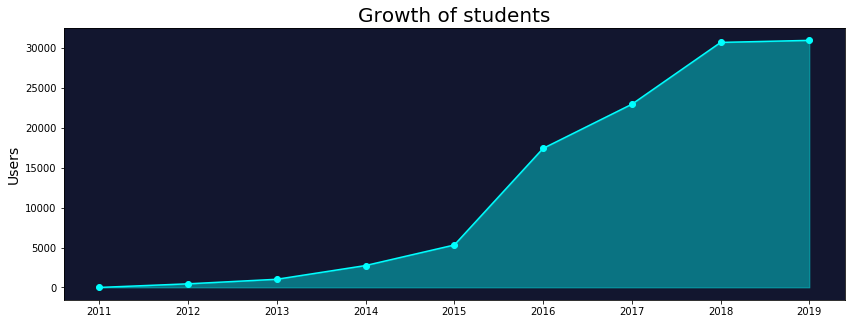

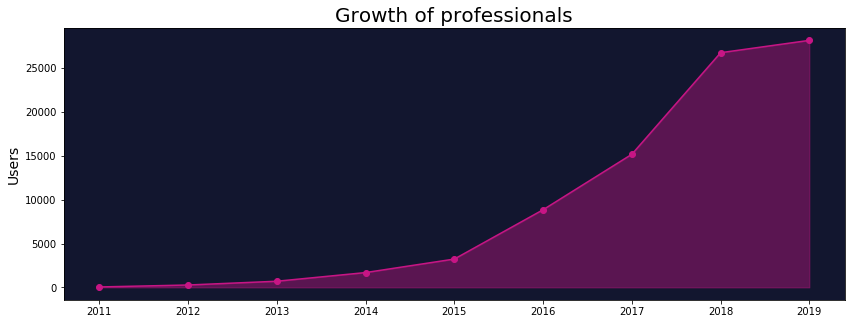

In [9]:
users = [
    ('students', students),
    ('professionals', professionals)
]

colors = {'students' : 'cyan', 'professionals' : 'mediumvioletred'}

for user, df in users:
    
    years = df['{}_date_joined'.format(user)].dt.year.unique()
    years.sort()
    
    min_date = df['{}_date_joined'.format(user)].min()
    min_date = min_date.strftime("%B %Y")
    
    max_date = df['{}_date_joined'.format(user)].max()
    max_date = max_date.strftime("%B %Y")
    
    
    amounts = [len(df[df['{}_date_joined'.format(user)].dt.year == y]) for y in years]
    
    for i in range(len(amounts)):
        if i > 0:
            amounts[i] += amounts[i - 1]
    to_plot = pd.DataFrame({'years': years, 'users': amounts})
    plt.figure(figsize=(14, 5))
    
    plt.plot('years', 'users', data=to_plot, marker='o', color=colors[user])
    x = to_plot['years']
    y = to_plot['users']
    plt.fill_between(x, y, color=colors[user], alpha = 0.4)
    
    plt.ylabel('Users', fontsize=14)
    plt.title('Growth of {}'.format(user), fontsize=20)
    plt.show()

### Number of items added per year


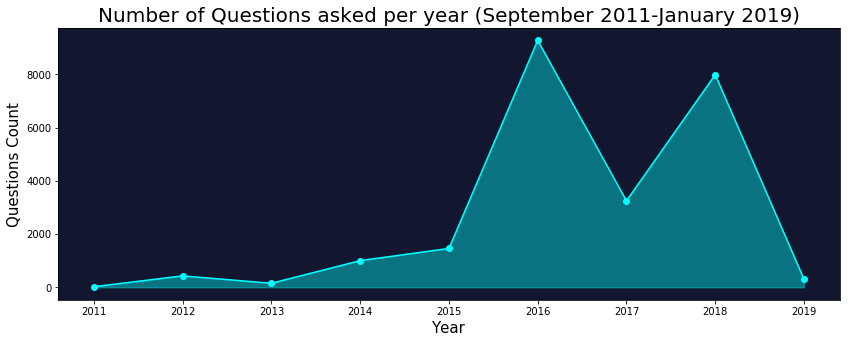

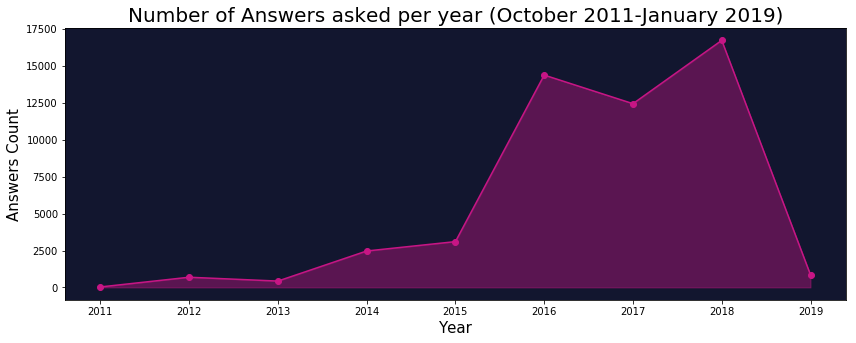

In [10]:
entities = [
    ('questions', questions),
    ('answers', answers)
]

colors = {'questions' : 'cyan', 'answers' : 'mediumvioletred'}

for entity, df in entities:
    min_date = df['{}_date_added'.format(entity)].min().strftime("%B %Y")
    max_date = df['{}_date_added'.format(entity)].max().strftime("%B %Y")

    df['year'] = df['{}_date_added'.format(entity)].dt.year
    plt_data = df.groupby('year').size()
    plt_data.plot(figsize=(14, 5), color=colors[entity],  marker='o')

    x = plt_data.reset_index()['year']
    y = plt_data.reset_index()[0]
    plt.fill_between(x, y, color=colors[entity], alpha = 0.4)

    plt.xlabel('Year', fontsize=15)
    plt.ylabel('{} Count'.format(entity.capitalize()), fontsize=15)
    plt.title('Number of {} asked per year ({}-{})'.format(entity.capitalize(), min_date, max_date), fontsize=20)
    plt.show()

### Professionals Answers & Students Questions amounts


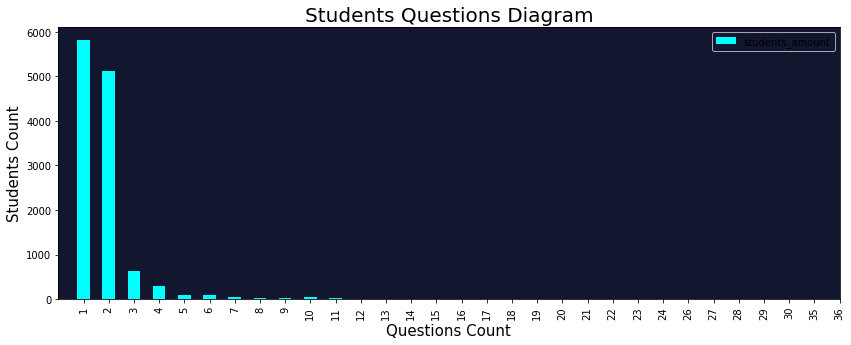

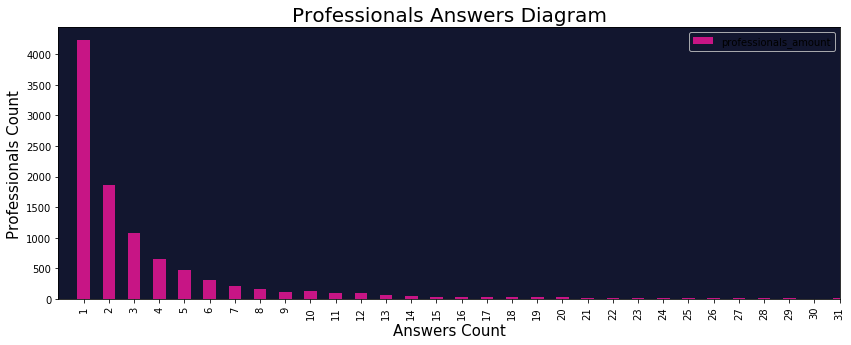

In [11]:
from collections import Counter 

ll = [
    ('students', 'questions', students, questions),
    ('professionals', 'answers', professionals, answers)
]

colors = {'students' : 'cyan', 'professionals' : 'mediumvioletred'}

for user, entity, user_df, entity_df in ll:
    tm = dict(sorted(Counter(pd.merge(user_df, entity_df, left_on='{}_id'.format(user), right_on='{}_author_id'.format(entity), how='inner').groupby('{}_id'.format(user)).size().values).items())) 
    t_d = {}
    t_d['{}_amount'.format(entity)] = list(tm.keys())
    t_d['{}_amount'.format(user)] = list(tm.values())

    plt_data = pd.DataFrame(t_d)

    plt_data.plot(x='{}_amount'.format(entity), y='{}_amount'.format(user), kind='bar', figsize=(14, 5), color=colors[user])
    plt.xlim(-1, 30)
    plt.xlabel('{} Count'.format(entity.capitalize()), fontsize=15)
    plt.ylabel('{} Count'.format(user.capitalize()), fontsize=15)
    plt.title('{} {} Diagram'.format(user.capitalize(), entity.capitalize()), fontsize=20)
    plt.show()


### Top n Professionals with most Answers & Students with most Questions


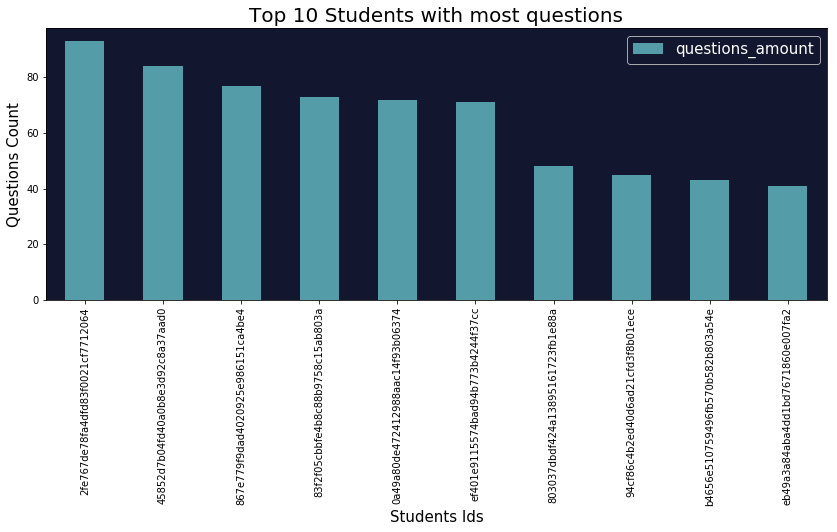

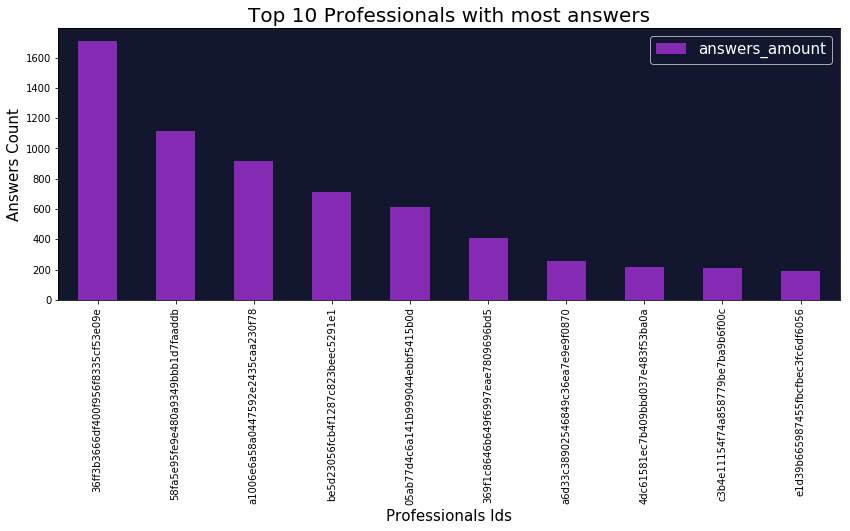

In [12]:
n = 10

ll = [
    ('students', 'questions', students, questions),
    ('professionals', 'answers', professionals, answers)
]

colors = {'students' : '#549da8', 'professionals' : '#852ab2'} 

for user, entity, user_df, entity_df in ll:
    top_n = pd.DataFrame(pd.merge(user_df, entity_df, left_on='{}_id'.format(user), right_on='{}_author_id'.format(entity), how='inner').groupby('{}_id'.format(user)).size().reset_index())
    plt_data = top_n.rename(index=str, columns={0: '{}_amount'.format(entity)}).sort_values(by=['{}_amount'.format(entity)], ascending=False)[:n]

    plt_data.plot(kind='bar', figsize=(14, 5), color=colors[user])
    plt.xticks(np.arange(len(plt_data)), tuple(plt_data['{}_id'.format(user)]), rotation=90)
    plt.xlabel('{} Ids'.format(user.capitalize()), fontsize=15)
    plt.ylabel('{} Count'.format(entity.capitalize()), fontsize=15)
    plt.title('Top {} {} with most {}'.format(n, user.capitalize(), entity), fontsize=20)
    leg = plt.legend(loc='best', fontsize=15)
    for text in leg.get_texts():
        plt.setp(text, color = 'w')
    plt.show()

### First activity after registration  <a id="eda_plots_fa"></a>
There are two general types of users:
- Activity right after registration
- No activity at all

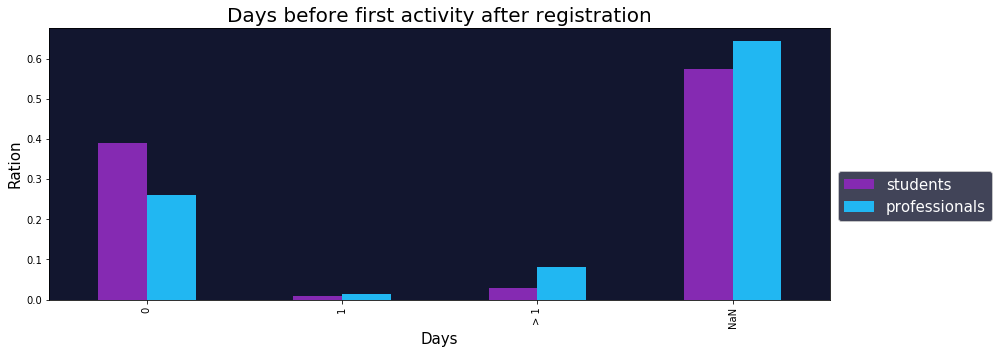

In [13]:
users = [
    ('students', students),
    ('professionals', professionals)
]

min_rel_date = '01-01-2016'
max_rel_date = '01-01-2019'

plt_data = {}

for user, df in users:
    df = df[(df['{}_date_joined'.format(user)] >= min_rel_date) & (df['{}_date_joined'.format(user)] <= max_rel_date)]
    df = (df['date_first_activity'] - df['{}_date_joined'.format(user)]).dt.days.fillna(10000).astype(int)
    df = df.groupby(df).size()/len(df)
    df = df.rename(lambda x: 0 if x < 0 else x)
    df = df.rename(lambda x: x if x <= 1 or x == 10000 else '> 1')
    df = df.rename({10000: 'NaN'})
    df = df.groupby(level=0).sum()

    plt_data[user] = df

plt_data = pd.DataFrame(plt_data)

plt_data.plot(kind='bar', figsize=(14, 5), colors=('#852ab2', '#21b7f2'))
plt.xlabel('Days', fontsize=15)
plt.ylabel('Ration', fontsize=15)
plt.title('Days before first activity after registration', fontsize=20)
leg = plt.legend(bbox_to_anchor=(1, 0.5), fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Last activity  <a id="eda_plots_la"></a>  


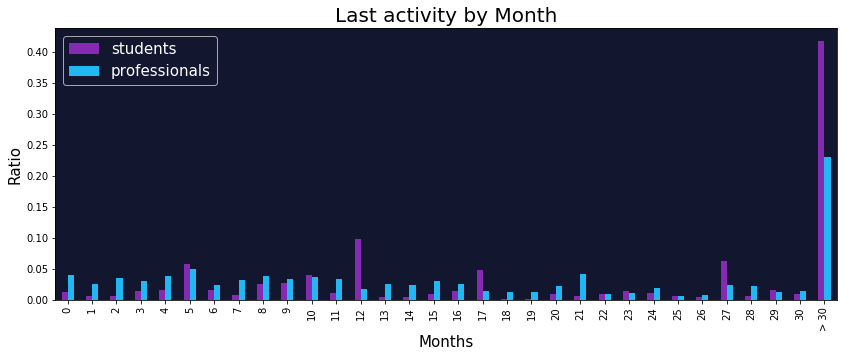

In [14]:
current_date = datetime(2019, 2 ,1)

users = [
    ('students', students),
    ('professionals', professionals)
]

plt_data = {}

for user, df in users:
    df = ((current_date - df['date_last_activity']).dt.days/30).dropna().astype(int)
    df = df.groupby(df).size()/len(df)
    df = df.rename(lambda x: 0 if x < 0 else x).rename(lambda x: x if x <= 30 or x == 10000 else '> 30').rename({10000:'NaN'})
    df = df.groupby(level=0).sum()

    plt_data[user] = df

plt_data = pd.DataFrame(plt_data)

plt_data.plot(kind='bar', figsize=(14, 5), colors=('#852ab2', '#21b7f2'))
plt.xlabel('Months', fontsize=15)
plt.ylabel('Ratio', fontsize=15)
plt.title('Last activity by Month', fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Days for first answer <a id="eda_plots_fa"></a>


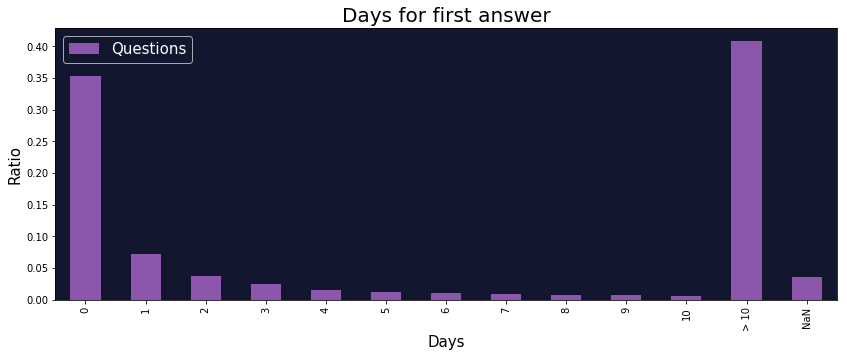

In [15]:
df = questions

min_rel_date = '01-01-2016'
max_rel_date = '01-01-2019'

tmp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').min()
df['questions_first_answers'] = pd.merge(questions, pd.DataFrame(tmp), left_on='questions_id', right_index=True, how='left')['answers_date_added']

df = df[(df['questions_date_added'] >= min_rel_date) & (df['questions_date_added'] <= max_rel_date)]
df = ((df['questions_first_answers'] - df['questions_date_added']).dt.days).fillna(10000).astype(int)
df = df.groupby(df).size()/len(df.index)
df = df.rename(lambda x: 0 if x < 0 else x)
df = df.rename(lambda x: x if x <= 10 or x == 10000 else '> 10')
df = df.rename({10000:'NaN'})
df = df.groupby(level=0).sum()

plt_data = pd.DataFrame({'Questions': df})

plt_data.plot(kind='bar', figsize=(14, 5), color='#8d56ad')
plt.xlabel('Days', fontsize=15)
plt.ylabel('Ratio', fontsize=15)
plt.title('Days for first answer', fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Mean response time per year


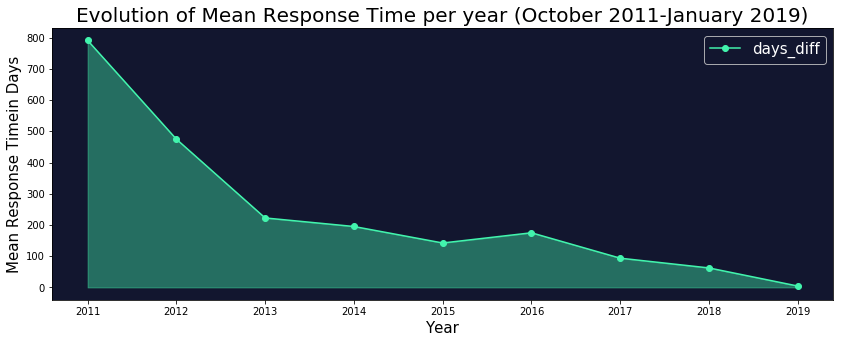

In [16]:
a_q = pd.merge(answers, questions, how='right', left_on='answers_question_id', right_on='questions_id')
a_q['days_diff'] = (a_q['answers_date_added'] - a_q['questions_date_added']).dt.days
plt_data = a_q[['year_y', 'days_diff']].groupby('year_y').mean()
plt_data.plot(figsize=(14, 5), color='#42f4ad',  marker='o')

x = plt_data.reset_index()['year_y']
y = plt_data.reset_index()['days_diff']
plt.fill_between(x, y, color='#42f4ad', alpha = 0.4)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Mean Response Timein Days', fontsize=15)
plt.title('Evolution of Mean Response Time per year ({0}-{1})'.format(min_date, max_date), fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Number of Emails sent per year


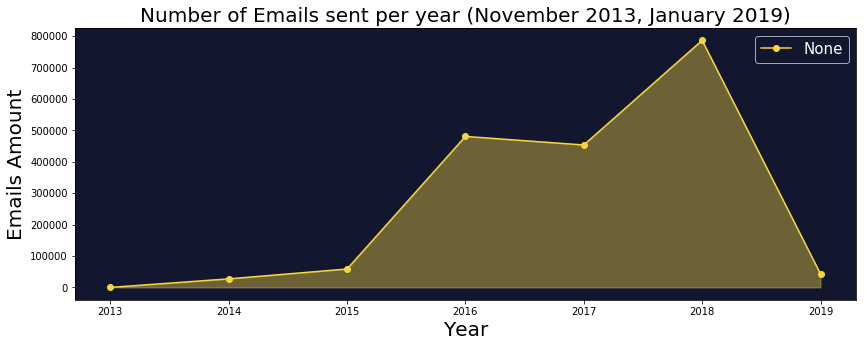

In [17]:
min_date = emails['emails_date_sent'].min().strftime("%B %Y")
max_date = emails['emails_date_sent'].max().strftime("%B %Y")

emails['year'] = emails['emails_date_sent'].dt.year
plt_data = emails.groupby('year').size()

plt_data.plot(figsize=(14, 5), color='#f4d641',  marker='o')

x = plt_data.reset_index()['year']
y = plt_data.reset_index()[0]
plt.fill_between(x, y, color='#f4d641', alpha = 0.4)

plt.xlabel('Year', fontsize=20)
plt.ylabel('Emails Amount', fontsize=20)
plt.title('Number of Emails sent per year ({0}, {1})'.format(min_date, max_date), fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### How many questions are contained in each email


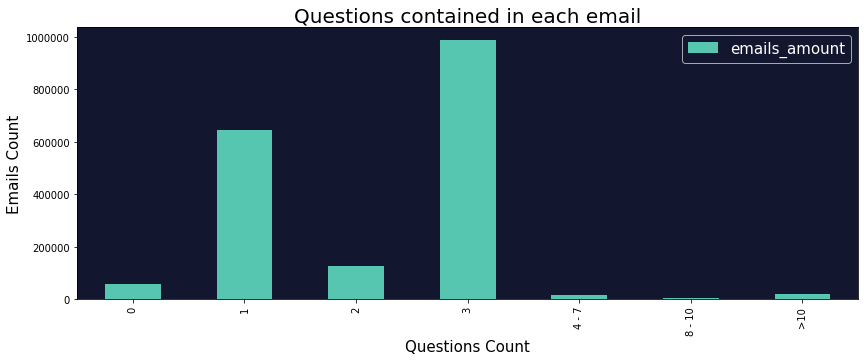

In [18]:
e_m = pd.DataFrame(pd.merge(emails, matches, how='inner', left_on='emails_id', right_on='matches_email_id').groupby('emails_id').size().reset_index()).rename(index=str, columns={0: "questions_amount"}).sort_values(by=['questions_amount'], ascending=False)
plt_data = e_m.groupby('questions_amount').size().reset_index().rename(index=str, columns={0: "emails_amount"})

mapping = {
    1: '1',
    2: '2',
    3: '3',
    4: '4 - 7',
    8: '8 - 10',
}

def get_key(x):
    for i in range(x, 0, -1):
        if i in mapping:
            return mapping[i]


plt_data['groups'] = plt_data['questions_amount'].apply(lambda x: '>10' if x >= 11 else get_key(x))
plt_data = pd.DataFrame({'groups' :['0'], 'emails_amount' : [len(emails) - len(e_m)]}).append(plt_data.groupby('groups').sum().reset_index()[['groups', 'emails_amount']])

plt_data.plot(kind='bar', figsize=(14, 5), color='#57c6b1')

plt.xticks(np.arange(len(plt_data)), tuple(plt_data['groups']))
plt.xlabel('Questions Count', fontsize=15)
plt.ylabel('Emails Count', fontsize=15)
plt.title('Questions contained in each email', fontsize=20)
leg = plt.legend(loc='best', fontsize=15)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.show()

### Tags Wordclouds <a id="eda_plots_tm"></a> 


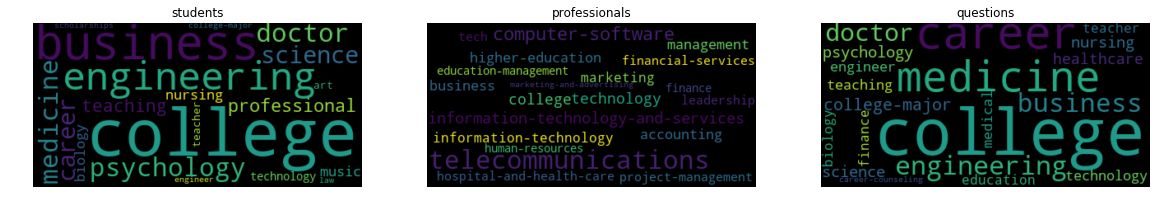

In [19]:
entities = [
    ('students', students),
    ('professionals', professionals),
    ('questions', questions)
]

dfs = []

for entity, df in entities:
    if entity == 'questions':
        df = tag_questions
        df = pd.merge(df, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
    else:
        df = tag_users[tag_users['tag_users_user_id'].isin(df['{}_id'.format(entity)])]
        df = pd.merge(df, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')

    df['entity_type'] = entity

    dfs.append(df)


plt_data = pd.concat(dfs)


plt_data = plt_data[['tags_tag_name', 'entity_type']].pivot_table(index='tags_tag_name', columns='entity_type', aggfunc=len, fill_value=0)

for entity, df in entities:
    plt_data[entity] = plt_data[entity] / len(df)

plt_data['sum'] = (plt_data['professionals'] + plt_data['students'] + plt_data['questions'])
plt_data = plt_data.sort_values(by='sum', ascending=False).drop(['sum'], axis=1).head(100)

plt.figure(figsize=(20, 20))
wordloud_values = ['students', 'professionals', 'questions']
axisNum = 1
for wordcloud_value in wordloud_values:
    wordcloud = WordCloud(margin=0, max_words=20, random_state=42).generate_from_frequencies(plt_data[wordcloud_value])
    ax = plt.subplot(1, 3, axisNum)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(wordcloud_value)
    plt.axis("off")
    axisNum += 1
plt.show()    

## NLP <a id="nlp"></a>

In [20]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

class TextProcessor:

    def __init__(self):
        self.stopwords = stopwords.words('english')
        self.ps = PorterStemmer()

        self.stemmed = dict()

    def process(self, text: str, allow_stopwords: bool = False) -> str:

        ret = []

        text = re.sub(r'<[^>]+>', ' ', str(text))
        for word in re.split('[^a-zA-Z]', str(text).lower()):
            if (word.isalpha() and word not in self.stopwords) or allow_stopwords:
                if word not in self.stemmed:
                    self.stemmed[word] = self.ps.stem(word)
                ret.append(self.stemmed[word])
        return ' '.join(ret)

In [21]:
tp = TextProcessor()

In [22]:
answers['answers_body'] = answers['answers_body'].apply(tp.process)
ans_train = answers[answers['answers_date_added'] < SPLIT_DATE]

questions['questions_title'] = questions['questions_title'].apply(tp.process)
questions['questions_body'] = questions['questions_body'].apply(tp.process)
questions['questions_whole'] = questions['questions_title'] + ' ' + questions['questions_body']
que_train = questions[questions['questions_date_added'] < SPLIT_DATE]

professionals['professionals_headline'] = professionals['professionals_headline'].apply(tp.process)
professionals['professionals_industry'] = professionals['professionals_industry'].apply(tp.process)
pro_train = professionals[professionals['professionals_date_joined'] < SPLIT_DATE]

stu_train = students[students['students_date_joined'] < SPLIT_DATE]

tags['tags_tag_name'] = tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))

tag_que = tag_questions.merge(tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
tag_pro = tag_users.merge(tags, left_on='tag_users_tag_id', right_on='tags_tag_id')

#### Training

In [23]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def train_d2v(df: pd.DataFrame, target: str, features: list, dim: int) -> (Doc2Vec, dict):

    prepared = []
    for feature in features:
        if feature != target:
            prepared += [TaggedDocument(row[feature].split(), [row[target]])
                         for i, row in df[[feature, target]].drop_duplicates().iterrows()]
        else:
            prepared += [TaggedDocument(s.split(), [s]) for s in df[target].drop_duplicates()]
    prepared = random.sample(prepared, len(prepared))
    d2v = Doc2Vec(prepared, vector_size=dim, workers=4, epochs=10, dm=0)
    docvecs = {d2v.docvecs.index2entity[i]: d2v.docvecs.vectors_docs[i]
               for i in range(len(d2v.docvecs.index2entity))}
    return d2v, docvecs


def pipeline_d2v(que: pd.DataFrame, ans: pd.DataFrame, pro: pd.DataFrame, tag_que: pd.DataFrame, tag_pro: pd.DataFrame,
                 dim: int) -> (dict, dict, Doc2Vec):

    pro_tags = tag_pro[['tag_users_user_id', 'tags_tag_name']].groupby(by='tag_users_user_id', as_index=False) \
        .aggregate(lambda x: ' '.join(x)).rename(columns={'tags_tag_name': 'tags_pro_name'})
    pro_tags = pro.merge(pro_tags, left_on='professionals_id', right_on='tag_users_user_id')

    # merge questions, tags, answers and professionals
    que_tags = que.merge(tag_que, left_on='questions_id', right_on='tag_questions_question_id')
    ans_que_tags = ans.merge(que_tags, left_on="answers_question_id", right_on="questions_id")
    df = ans_que_tags.merge(pro_tags, left_on='answers_author_id', right_on='professionals_id')

    text_features = ['questions_title', 'questions_body', 'answers_body', 'tags_tag_name', 'tags_pro_name',
                     'professionals_industry', 'professionals_headline']

    _, tags_embs = train_d2v(df, 'tags_tag_name', text_features, dim)

    que_tags = que_tags[['questions_id', 'tags_tag_name']].groupby(by='questions_id', as_index=False) \
        .aggregate(lambda x: ' '.join(x))

    que_tags = que.merge(que_tags, on='questions_id')
    ans_que_tags = ans.merge(que_tags, left_on="answers_question_id", right_on="questions_id")
    df = ans_que_tags.merge(pro_tags, left_on='answers_author_id', right_on='professionals_id')

    _, inds_embs = train_d2v(df, 'professionals_industry', text_features, dim)

    head_d2v, _ = train_d2v(df, 'professionals_headline', text_features, 5)

    ques_d2v, _ = train_d2v(que_tags, 'questions_id', ['questions_whole'], dim)

    return tags_embs, inds_embs, head_d2v, ques_d2v

In [24]:
n_emb = 10
tag_embs, ind_embs, head_d2v, ques_d2v = pipeline_d2v(que_train, ans_train, pro_train, tag_que, tag_pro, n_emb)

#### Visualization

In [25]:
from sklearn.manifold import TSNE

def vis_emb(id_to_vec: dict, occurrences: pd.Series, title: str):

    top = set(occurrences.value_counts().iloc[:100].index)
    filtered = {key: value for key, value in id_to_vec.items() if key in top}
    
    proj = TSNE(n_components=2).fit_transform(np.vstack(filtered.values()))
    
    _, ax = plt.subplots(figsize=(12, 12))
    plt.scatter(proj[:, 0], proj[:, 1], alpha=0.7, s=90, c='#69f0ff')
    for i, name in enumerate(filtered.keys()):
        ax.annotate(name, (proj[i, 0], proj[i, 1]), color='w')
        
    ax.set_title(title, fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.show()

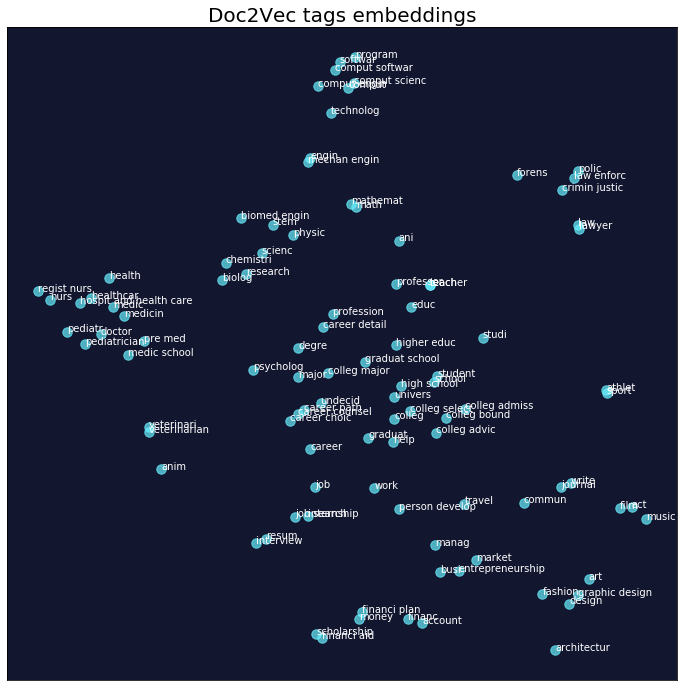

In [26]:
vis_emb(tag_embs, tag_que['tags_tag_name'], 'Doc2Vec tags embeddings')

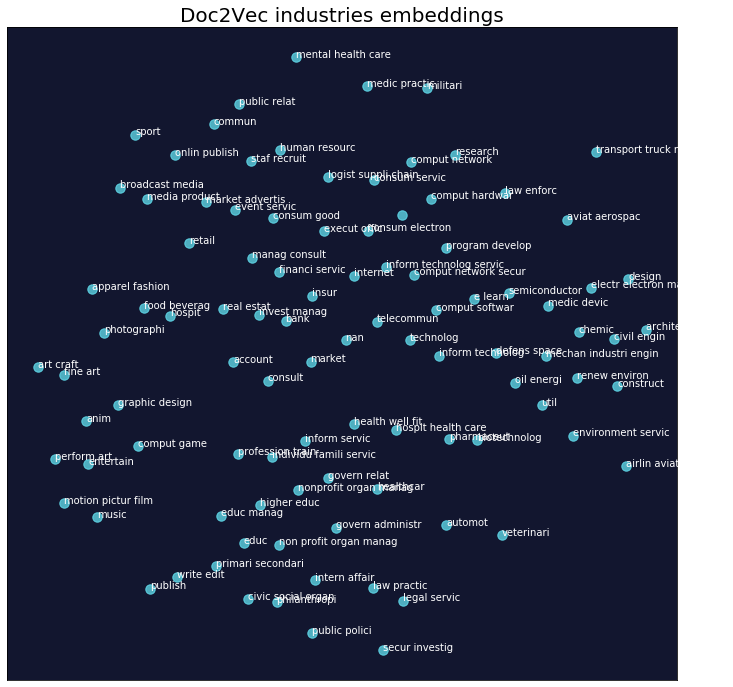

In [27]:
vis_emb(ind_embs, pro_train['professionals_industry'], 'Doc2Vec industries embeddings')

#### Training


In [28]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore

def pipeline_lda(que: pd.DataFrame, dim: int) -> (Dictionary, TfidfModel, LdaMulticore):

    lda_tokens = que['questions_whole'].apply(lambda x: x.split())


    lda_dic = Dictionary(lda_tokens)
    lda_dic.filter_extremes(no_below=10, no_above=0.6, keep_n=8000)
    lda_corpus = [lda_dic.doc2bow(doc) for doc in lda_tokens]


    lda_tfidf = TfidfModel(lda_corpus)
    lda_corpus = lda_tfidf[lda_corpus]

    lda_model = LdaMulticore(
        lda_corpus, num_topics=dim, id2word=lda_dic, workers=4,
        passes=20, chunksize=1000, random_state=0
    )

    return lda_dic, lda_tfidf, lda_model

In [29]:
lda_dic, lda_tfidf, lda_model = pipeline_lda(que_train, n_emb)

#### Visualization


In [30]:
def plot_lda_wordcloud(lda_model, rows, columns):

    n_ax = 0
    plt.figure(figsize=(5*columns, 2*rows))
    for t_id in range(lda_model.state.get_lambda().shape[0]):
        topics_terms = lda_model.state.get_lambda()
        tmp = {}
        for i in range(1, len(topics_terms[0])):
            tmp[lda_model.id2word[i]]=topics_terms[t_id,i]

        wordcloud = WordCloud(margin=0, max_words=15).generate_from_frequencies(tmp)
        n_ax += 1
        ax = plt.subplot(rows, columns, n_ax)

        plt.imshow(wordcloud, interpolation='bilinear')
        title = t_id
        plt.title(title)
        plt.axis("off")
        plt.margins(x=0, y=0)

    plt.show()

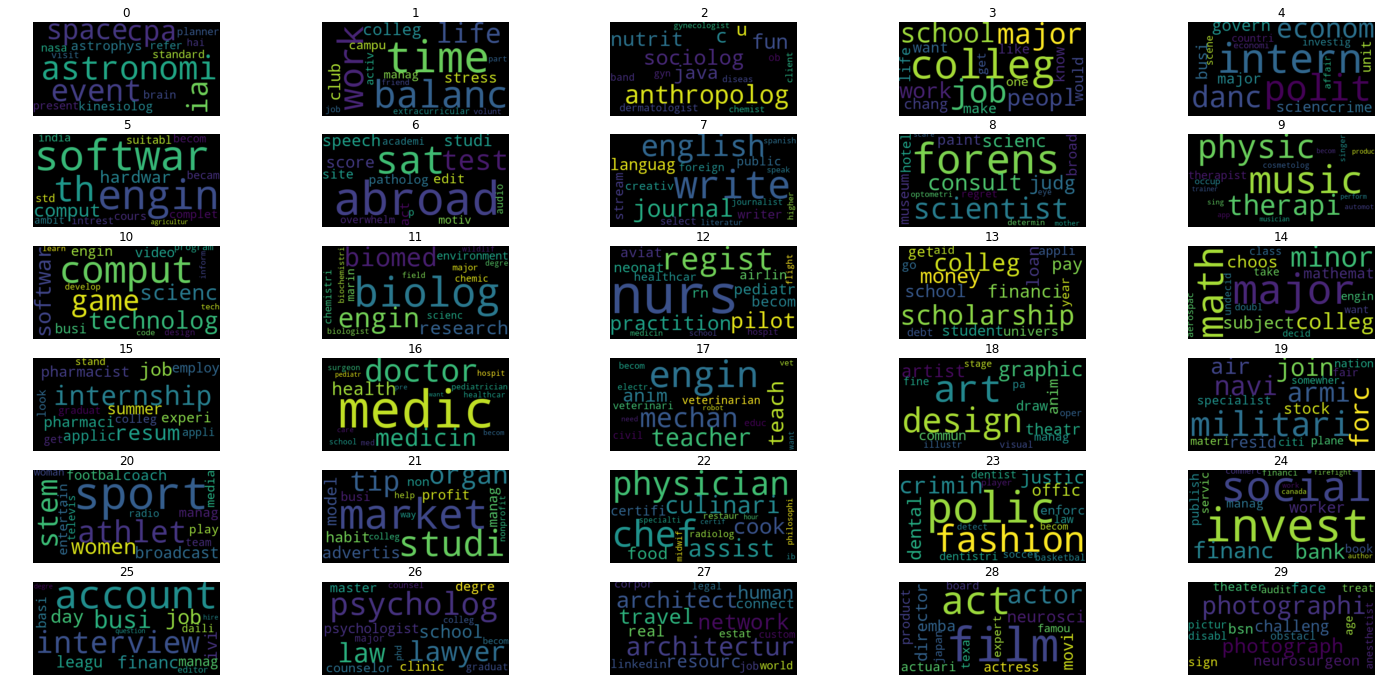

In [31]:
_, _, lda_for_vis_model = pipeline_lda(que_train, 30)
plot_lda_wordcloud(lda_for_vis_model, 6, 5)

## Feature Engineering <a id="feature_engineering"></a>

In [32]:
from abc import ABC
from sklearn.preprocessing import StandardScaler, LabelEncoder

class BaseProc(ABC):
    def __init__(self):
        self.pp = {}
        self.features = {
            'categorical': [],
            'numerical': {'zero': [], 'mean': []},
            'date': []
        }

    def _unroll_features(self):
        self.features['all'] = ([name for name, deg in self.features['categorical']]
                                if 'categorical' in self.features else []) + \
                               (self.features['numerical']['zero'] + self.features['numerical']['mean']
                                if 'numerical' in self.features else []) + \
                               ([f + p for f in self.features['date']
                                 for p in ['_time', '_doy_sin', '_doy_cos']]
                                if 'date' in self.features else [])

    def datetime(self, df: pd.DataFrame, feature: str):

        for suf, fun in [('_time', lambda d: d.year + (d.dayofyear + d.hour / 24) / 365),
                         ('_doy_sin', lambda d: np.sin(2 * np.pi * d.dayofyear / 365)),
                         ('_doy_cos', lambda d: np.cos(2 * np.pi * d.dayofyear / 365))]:
            df[feature + suf] = df[feature].apply(fun)
            # add created feature to the list of generated features
            self.features['gen'].append(feature + suf)

        df.drop(columns=feature, inplace=True)

    def __get_preprocessor(self, fit_data: np.array, feature: str, base):
 
        if feature in self.pp:
            preproc = self.pp[feature]
        else:
            preproc = base()
            preproc.fit(fit_data)
            self.pp[feature] = preproc
        return preproc

    def numerical(self, df: pd.DataFrame, feature: str, fillmode: str):

        if fillmode == 'mean':
            if feature in self.pp:
                na = self.pp[feature].mean_[0]
            else:
                na = df[feature].mean()
        else:
            na = 0

        df[feature].fillna(na, inplace=True)

        fit_data = df[feature].values.reshape(-1, 1).astype('float64')
        sc = self.__get_preprocessor(fit_data, feature, StandardScaler)
        df[feature] = sc.transform(fit_data)

    def categorical(self, df: pd.DataFrame, feature: str, n: int):
        vc = df[feature].value_counts()

        n = len(vc) if n == 0 else n
         top = set(vc[:n].index)
        isin_top = df[feature].isin(top)

        fit_data = df.loc[isin_top, feature]
        le = self.__get_preprocessor(fit_data, feature, LabelEncoder)

        isin_le = df[feature].isin(set(le.classes_))
        df.loc[isin_le, feature] = le.transform(df.loc[isin_le, feature])

        bottom = set(vc.index) - set(le.classes_)
        isin_bottom = df[feature].isin(bottom)
        df.loc[isin_bottom, feature] = n

        df[feature].fillna(n + 1, inplace=True)

    def preprocess(self, df: pd.DataFrame):
        self.features['gen'] = []
        if 'date' in self.features:
            for feature in self.features['date']:
                self.datetime(df, feature)

      
        if 'numerical' in self.features:
            for fillmode in self.features['numerical']:
                for feature in self.features['numerical'][fillmode] + \
                               (self.features['gen'] if fillmode == 'mean' else []):
                    if feature in df.columns:
                        self.numerical(df, feature, fillmode)

        if 'categorical' in self.features:
            for feature, n in self.features['categorical']:
                self.categorical(df, feature, n)

In [33]:
class Averager:
   
    def __init__(self):
        self.sum = 0
        self.cnt = 0

    def upd(self, val):
        self.sum += val
        self.cnt += 1

    def get(self):
        if self.cnt == 0:
            return None
        return self.sum / self.cnt

In [34]:
class QueProc(BaseProc):

    def __init__(self, tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model):
        super().__init__()

        self.tag_embs = tag_embs
        self.ques_d2v = ques_d2v

        self.lda_dic = lda_dic
        self.lda_tfidf = lda_tfidf
        self.lda_model = lda_model

        self.features = {
            'numerical': {
                'zero': ['questions_body_length', 'questions_tag_count'],
                'mean': []
            }
        }

        self._unroll_features()

    def transform(self, que, tags):

        que['questions_time'] = que['questions_date_added']
        que['questions_body_length'] = que['questions_body'].apply(lambda s: len(str(s)))

        tags_grouped = tags.groupby('tag_questions_question_id', as_index=False)[['tags_tag_name']] \
            .agg(lambda x: ' '.join(set(x)))
        tags_grouped['questions_tag_count'] = tags_grouped['tags_tag_name'].apply(lambda x: len(x.split()))
        df = que.merge(tags_grouped, how='left', left_on='questions_id', right_on='tag_questions_question_id')

        self.preprocess(df)


        tag_emb_len = list(self.tag_embs.values())[0].shape[0]

        def __convert(s):
            embs = []
            for tag in str(s).split():
                if tag in self.tag_embs:
                    embs.append(self.tag_embs[tag])
            if len(embs) == 0:
                embs.append(np.zeros(tag_emb_len))
            return np.vstack(embs).mean(axis=0)

        mean_embs = df['tags_tag_name'].apply(__convert)

        lda_emb_len = len(self.lda_model[[]])
        lda_corpus = [self.lda_dic.doc2bow(doc) for doc in df['questions_whole'].apply(lambda x: x.split())]
        lda_corpus = self.lda_tfidf[lda_corpus]
        lda_que_embs = self.lda_model.inference(lda_corpus)[0]

        d2v_emb_len = len(self.ques_d2v.infer_vector([]))

        def __infer_d2v(s):
            self.ques_d2v.random.seed(0)
            return self.ques_d2v.infer_vector(s.split(), steps=100)

        d2v_que_embs = df['questions_whole'].apply(__infer_d2v)

        df = df[['questions_id', 'questions_time'] + self.features['all']]

        for i in range(lda_emb_len):
            df[f'que_lda_emb_{i}'] = lda_que_embs[:, i]

        for i in range(d2v_emb_len):
            df[f'que_d2v_emb_{i}'] = d2v_que_embs.apply(lambda x: x[i])

        for i in range(tag_emb_len):
            df[f'que_tag_emb_{i}'] = mean_embs.apply(lambda x: x[i])

        return df

In [35]:
que_proc = QueProc(tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model)
que_data = que_proc.transform(que_train, tag_que)

In [36]:
class StuProc(BaseProc):
    def __init__(self):
        super().__init__()

        self.features = {
            'categorical': [('students_location', 100), ('students_state', 40)],
            'numerical': {
                'zero': ['students_questions_asked'],
                'mean': ['students_average_question_body_length', 'students_average_answer_body_length',
                         'students_average_answer_amount']
            },
            'date': []
        }

        self._unroll_features()

    def transform(self, stu, que, ans) -> pd.DataFrame:

        stu['students_state'] = stu['students_location'].apply(lambda s: str(s).split(', ')[-1])

        que['questions_body_length'] = que['questions_body'].apply(lambda s: len(str(s)))
        ans['answers_body_length'] = ans['answers_body'].apply(lambda s: len(str(s)))

       
        que_change = stu.merge(que, left_on='students_id', right_on='questions_author_id')
        ans_change = que_change.merge(ans, left_on='questions_id', right_on='answers_question_id') \
            .rename(columns={'answers_date_added': 'students_time'})

       
        ans_change['change_type'] = 'answer'
        que_change['change_type'] = 'question'
        que_change = que_change.rename(columns={'questions_date_added': 'students_time'})

       
        df = pd.concat([que_change, ans_change], ignore_index=True, sort=True).sort_values('students_time')

        data = {}
        avgs = {}

        for i, row in stu.iterrows():
            cur_stu = row['students_id']
        
            if cur_stu not in data:
                new = {'students_questions_asked': 0,
                       'students_previous_question_time': row['students_date_joined']}
                for feature in ['students_time'] + self.features['numerical']['mean']:
                    new[feature] = None
                data[cur_stu] = [new]
                avgs[cur_stu] = {feature: Averager() for feature in self.features['numerical']['mean']}
        
        for i, row in df.iterrows():
            cur_stu = row['students_id']

            prv = data[cur_stu][-1]
            new = prv.copy()

            new['students_time'] = row['students_time']

            if row['change_type'] == 'question':
                new['students_questions_asked'] += 1
                new['students_previous_question_time'] = row['questions_date_added']
                new['students_average_question_body_length'] = row['questions_body_length']
            else:  
                new['students_average_answer_body_length'] = row['answers_body_length']
                new['students_average_answer_amount'] = new['students_average_answer_amount'] + 1 \
                    if new['students_average_answer_amount'] is not None else 1

            for feature in ['students_average_question_body_length'] if row['change_type'] == 'question' else \
                    ['students_average_answer_body_length', 'students_average_answer_amount']:
                avgs[cur_stu][feature].upd(new[feature])
                new[feature] = avgs[cur_stu][feature].get()

            data[cur_stu].append(new)

        df = pd.DataFrame([{**f, **{'students_id': id}} for (id, fs) in data.items() for f in fs])

        df = df.merge(stu, on='students_id')
        self.preprocess(df)

        df = df[['students_id', 'students_time'] + self.features['all']]

        return df

In [37]:
stu_proc = StuProc()
stu_data = stu_proc.transform(stu_train, que_train, ans_train)

In [38]:
class ProProc(BaseProc):

    def __init__(self, tag_embs, ind_embs, head_d2v, ques_d2v):
        super().__init__()

        self.tag_embs = tag_embs
        self.ind_embs = ind_embs

        self.head_d2v = head_d2v
        self.ques_d2v = ques_d2v

        self.features = {
            'categorical': [('professionals_industry', 100), ('professionals_location', 100),
                            ('professionals_state', 40)],
            'numerical': {
                'zero': [],  # ['professionals_questions_answered'],
                'mean': ['professionals_average_question_body_length',
                         'professionals_average_answer_body_length']
            }
        }

        self._unroll_features()


    def transform(self, pro, que, ans, tags) -> pd.DataFrame:

        tags_grouped = tags.groupby('tag_users_user_id', as_index=False)[['tags_tag_name']] \
            .aggregate(lambda x: ' '.join(set(x)))

        pro['professionals_industry_raw'] = pro['professionals_industry']
        pro['professionals_state'] = pro['professionals_location'].apply(lambda loc: str(loc).split(', ')[-1])
        que['questions_body_length'] = que['questions_body'].apply(lambda s: len(str(s)))
        ans['answers_body_length'] = ans['answers_body'].apply(lambda s: len(str(s)))

        df = pro.merge(ans, left_on='professionals_id', right_on='answers_author_id') \
            .merge(que, left_on='answers_question_id', right_on='questions_id') \
            .sort_values('answers_date_added')

        data = {}
        que_emb_len = len(self.ques_d2v.infer_vector([]))

        for i, row in pro.iterrows():
            cur_pro = row['professionals_id']

            if cur_pro not in data:
                new = {'professionals_questions_answered': 0,
                       'professionals_previous_answer_date': row['professionals_date_joined']}
                for feature in ['professionals_time', 'professionals_average_question_age',
                                'professionals_average_question_body_length',
                                'professionals_average_answer_body_length']:
                    new[feature] = None
                new['pro_que_emb'] = np.zeros(que_emb_len)
                data[cur_pro] = [new]

        def __infer_d2v(s):
            self.ques_d2v.random.seed(0)
            return self.ques_d2v.infer_vector(s.split(), steps=100)

        for i, row in df.iterrows():
            cur_pro = row['professionals_id']

            prv = data[cur_pro][-1]
            new = {'professionals_time': row['answers_date_added'],
                   'professionals_questions_answered': prv['professionals_questions_answered'] + 1,
                   'professionals_previous_answer_date': row['answers_date_added'],
                   'professionals_average_question_age':
                       (row['answers_date_added'] - row['questions_date_added']) / np.timedelta64(1, 's'),
                   'professionals_average_question_body_length': row['questions_body_length'],
                   'professionals_average_answer_body_length': row['answers_body_length'],
                   'pro_que_emb': __infer_d2v(row['questions_whole'])}
            length = len(data[cur_pro])
            if length != 1:
                for feature in ['professionals_average_question_age', 'professionals_average_question_body_length',
                                'professionals_average_answer_body_length', 'pro_que_emb']:
                    new[feature] = (prv[feature] * (length - 1) + new[feature]) / length
            data[cur_pro].append(new)

        df = pd.DataFrame([{**f, **{'professionals_id': id}} for (id, fs) in data.items() for f in fs])

        df = df.merge(pro, on='professionals_id').merge(tags_grouped, how='left', left_on='professionals_id',
                                                        right_on='tag_users_user_id')

        self.preprocess(df)

        tag_emb_len = list(self.tag_embs.values())[0].shape[0]

        def __convert_tag(s):
            embs = []
            for tag in str(s).split():
                if tag in self.tag_embs:
                    embs.append(self.tag_embs[tag])
            if len(embs) == 0:
                embs.append(np.zeros(tag_emb_len))
            return np.vstack(embs).mean(axis=0)

        mean_tag_embs = df['tags_tag_name'].apply(__convert_tag)

        industry_emb_len = list(self.ind_embs.values())[0].shape[0]
        ind_embs = df['professionals_industry_raw'] \
            .apply(lambda x: self.ind_embs.get(x, np.zeros(industry_emb_len)))

        head_emb_len = len(self.head_d2v.infer_vector([]))

        def __convert_headline(s):
            self.head_d2v.random.seed(0)
            return self.head_d2v.infer_vector(s.split(), steps=100)

        head_embs = df['professionals_headline'].apply(__convert_headline)

        que_embs = df['pro_que_emb']

        df = df[['professionals_id', 'professionals_time'] + self.features['all']]

        for i in range(tag_emb_len):
            df[f'pro_tag_emb_{i}'] = mean_tag_embs.apply(lambda x: x[i])

        for i in range(industry_emb_len):
            df[f'pro_ind_emb_{i}'] = ind_embs.apply(lambda x: x[i])

        for i in range(head_emb_len):
            df[f'pro_head_emb_{i}'] = head_embs.apply(lambda x: x[i])

        for i in range(que_emb_len):
            df[f'pro_que_emb_{i}'] = que_embs.apply(lambda x: x[i])

        return df

In [39]:
pro_proc = ProProc(tag_embs, ind_embs, head_d2v, ques_d2v)
pro_data = pro_proc.transform(pro_train, que_train, ans_train, tag_pro)

### Data ingestion <a id="di"></a>

In [40]:

pairs_df = questions.merge(answers, left_on='questions_id', right_on='answers_question_id') \
    .merge(professionals, left_on='answers_author_id', right_on='professionals_id') \
    .merge(students, left_on='questions_author_id', right_on='students_id')

pairs_df = pairs_df[['questions_id', 'students_id', 'professionals_id', 'answers_date_added']]

pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] < SPLIT_DATE].itertuples(index=False, name=None))


pro_answers = pairs_df.drop(columns=['students_id']).set_index('professionals_id')

### Batch generator  <a id="di_batch_generator"></a>

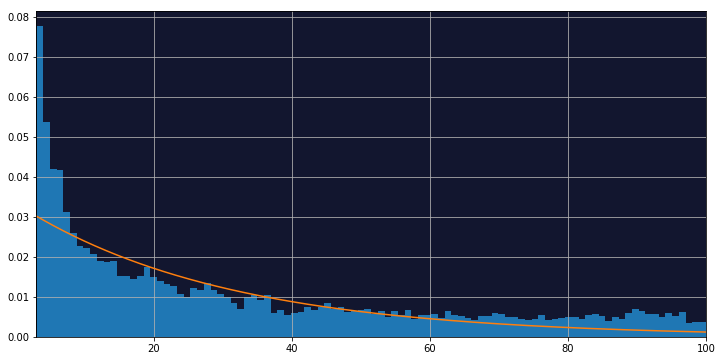

In [41]:
qa_data = questions.merge(answers, left_on='questions_id', right_on='answers_question_id')

que_age = pd.to_datetime(qa_data['answers_date_added']) - pd.to_datetime(qa_data['questions_date_added'])
que_age = que_age.apply(lambda x: x.days + np.round(x.seconds / 3600) / 24)

fig, ax = plt.subplots(figsize=(12,6))

cut_que_age = que_age[(que_age < 100) & (que_age > 3)]
cut_que_age.hist(bins=100, density=True)

mean = 30
lambd = 1 / mean

x = np.linspace(0, 100, 1000)
y = lambd * np.exp(-lambd * x)

ax.plot(x, y)
ax.set_xlim(3, 100)

plt.show()

In [42]:
class BatchGenerator(keras.utils.Sequence):

    
    exp_mean = 30
    
    def __init__(self, que: pd.DataFrame, stu: pd.DataFrame, pro: pd.DataFrame,
                 batch_size: int, pos_pairs: list, nonneg_pairs: list, pro_dates: dict):

        self.batch_size = batch_size

        que_ar = que.values
        self.que_feat = {que_ar[i, 0]: que_ar[i, 2:] for i in range(que_ar.shape[0])}
        self.que_time = {que_ar[i, 0]: pd.Timestamp(que_ar[i, 1]) for i in range(que_ar.shape[0])}

        self.pos_pairs = pos_pairs
        self.on_epoch_end()  # shuffle pos_pairs
        self.nonneg_pairs = {(que, stu, pro) for que, stu, pro, time in nonneg_pairs}

        self.ques_stus_times = [(que, stu, self.que_time[que]) for que, stu, pro, time in pos_pairs]

        self.pros = np.array([pro for que, stu, pro, time in nonneg_pairs])
        self.pros_times = np.array([pro_dates[pro] for que, stu, pro, time in nonneg_pairs])

        sorted_args = np.argsort(self.pros_times)
        self.pros = self.pros[sorted_args]
        self.pros_times = self.pros_times[sorted_args]

        self.stu_feat = {}
        self.stu_time = {}
        for stu_id, group in stu.groupby('students_id'):
            group_ar = group.values[:, 1:]
            self.stu_feat[stu_id] = np.array([group_ar[i, 1:] for i in range(group_ar.shape[0])])
            self.stu_time[stu_id] = np.array([group_ar[i, 0] for i in range(group_ar.shape[0])])

        self.pro_feat = {}
        self.pro_time = {}
        for pro_id, group in pro.groupby('professionals_id'):
            group_ar = group.values[:, 1:]
            self.pro_feat[pro_id] = np.array([group_ar[i, 1:] for i in range(group_ar.shape[0])])
            self.pro_time[pro_id] = np.array([group_ar[i, 0] for i in range(group_ar.shape[0])])

    def __len__(self):
        return len(self.pos_pairs) // self.batch_size

    @staticmethod
    def __find(feat_ar: np.ndarray, time_ar: np.ndarray, search_time):
        pos = np.searchsorted(time_ar[1:], search_time)
        assert time_ar[pos] is pd.NaT or time_ar[pos] < search_time
        return feat_ar[pos]

    def __convert(self, pairs: list) -> (np.ndarray, np.ndarray):

        x_que, x_pro, current_times = [], [], []
        for que, stu, pro, current_time in pairs:
            que_data = self.que_feat[que]

            
            stu_data = BatchGenerator.__find(self.stu_feat[stu], self.stu_time[stu], current_time)
            pro_data = BatchGenerator.__find(self.pro_feat[pro], self.pro_time[pro], current_time)

            current_time = current_time.year + (current_time.dayofyear + current_time.hour / 24) / 365
            current_times.append(current_time)

            x_que.append(np.hstack([stu_data, que_data]))
            x_pro.append(pro_data)

        return np.vstack(x_que), np.vstack(x_pro)

    def __getitem__(self, index):
 
        pos_pairs = self.pos_pairs[self.batch_size * index: self.batch_size * (index + 1)]
        neg_pairs = []

        for i in range(len(pos_pairs)):
            while True:
                
                que, stu, zero = random.choice(self.ques_stus_times)
               
                shift = np.random.exponential(BatchGenerator.exp_mean)
                current_time = zero + pd.Timedelta(int(shift * 24 * 60), 'm')
                
                i = np.searchsorted(self.pros_times, current_time)
                if i != 0:
                    break

            while True:

                pro = random.choice(self.pros[:i])

                if (que, stu, pro) not in self.nonneg_pairs:
                    neg_pairs.append((que, stu, pro, current_time))
                    break

        x_pos_que, x_pos_pro = self.__convert(pos_pairs)
        x_neg_que, x_neg_pro = self.__convert(neg_pairs)

        return [np.vstack([x_pos_que, x_neg_que]), np.vstack([x_pos_pro, x_neg_pro])], \
               np.vstack([np.ones((len(x_pos_que), 1)), np.zeros((len(x_neg_que), 1))])

    def on_epoch_end(self):

        self.pos_pairs = random.sample(self.pos_pairs, len(self.pos_pairs))

In [43]:
pro_to_date = {row['professionals_id']: row['professionals_date_joined'] for i, row in professionals.iterrows()}

In [44]:
bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, pos_pairs, pro_to_date)

### Neural Network Architecture <a id="nna"></a>

In [45]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Embedding, Concatenate, Layer
from keras.optimizers import Adam


def l2_reg_last_n(alpha: float, n: int):

    return lambda w: alpha * tf.reduce_mean(tf.square(w[-n:, :]))


def categorize(inputs: tf.Tensor, emb_input_dims: list, emb_output_dims: list):
    n_embs = len(emb_input_dims)

    if n_embs > 0:
        embs = []

        for i, nunique, dim in zip(range(n_embs), emb_input_dims, emb_output_dims):

            tmp = Lambda(lambda x: x[:, i])(inputs)

            embs.append(Embedding(nunique, dim)(tmp))

        embs.append(Lambda(lambda x: x[:, n_embs:])(inputs))

        outputs = Concatenate()(embs)
    else:
        outputs = inputs

    return outputs


class Encoder(Model):

    def __init__(self, input_dim: int, inter_dim: int, output_dim: int, emb_input_dims: list, emb_output_dims: list,
                 reg: float = 0.0):

        self.inputs = Input((input_dim,))
        self.categorized = categorize(self.inputs, emb_input_dims, emb_output_dims)

        self.inter = Dense(inter_dim, activation='tanh',
                           kernel_regularizer=l2_reg_last_n(reg, 10))(self.categorized)

        self.outputs = Dense(output_dim)(self.inter)

        super().__init__(self.inputs, self.outputs)


class DistanceModel(Model):


    def __init__(self, que_dim: int, que_input_embs: list, que_output_embs: list,
                 pro_dim: int, pro_input_embs: list, pro_output_embs: list,
                 inter_dim: int, output_dim: int):

        super().__init__()


        self.que_model = Encoder(que_dim, inter_dim, output_dim, que_input_embs, que_output_embs, reg=2.0)

        self.pro_model = Encoder(pro_dim, inter_dim, output_dim, pro_input_embs, pro_output_embs, reg=0.2)

        self.merged = Lambda(lambda x: tf.reduce_sum(tf.square(x[0] - x[1]), axis=-1))(
            [self.que_model.outputs[0], self.pro_model.outputs[0]])
        self.outputs = Lambda(lambda x: tf.reshape(tf.exp(-self.merged), (-1, 1)))(self.merged)

        super().__init__([self.que_model.inputs[0], self.pro_model.inputs[0]], self.outputs)

In [46]:
model = DistanceModel(que_dim=len(que_data.columns) - 2 + len(stu_data.columns) - 2,
                      que_input_embs=[102, 42], que_output_embs=[2, 2],
                      pro_dim=len(pro_data.columns) - 2,
                      pro_input_embs=[102, 102, 42], pro_output_embs=[2, 2, 2],
                      inter_dim=20, output_dim=10)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None,)              0           input_1[0][0]                    
_____________________________________

In [47]:
for lr, epochs in zip([0.01, 0.001, 0.0001, 0.00001], [5, 10, 10, 5]):
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit_generator(bg, epochs=epochs, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 10s - loss: 0.6189 - acc: 0.6830
Epoch 2/5
 - 9s - loss: 0.5681 - acc: 0.7159
Epoch 3/5
 - 9s - loss: 0.5635 - acc: 0.7231
Epoch 4/5
 - 9s - loss: 0.5609 - acc: 0.7238
Epoch 5/5
 - 9s - loss: 0.5568 - acc: 0.7264
Epoch 1/10
 - 10s - loss: 0.5265 - acc: 0.7506
Epoch 2/10
 - 9s - loss: 0.5215 - acc: 0.7540
Epoch 3/10
 - 9s - loss: 0.5201 - acc: 0.7556
Epoch 4/10
 - 9s - loss: 0.5165 - acc: 0.7583
Epoch 5/10
 - 9s - loss: 0.5141 - acc: 0.7606
Epoch 6/10
 - 9s - loss: 0.5122 - acc: 0.7614
Epoch 7/10
 - 9s - loss: 0.5125 - acc: 0.7610
Epoch 8/10
 - 9s - loss: 0.5109 - acc: 0.7628
Epoch 9/10
 - 9s - loss: 0.5083 - acc: 0.7623
Epoch 10/10
 - 9s - loss: 0.5089 - acc: 0.7620
Epoch 1/10
 - 10s - loss: 0.5028 - acc: 0.7676
Epoch 2/10
 - 9s - loss: 0.5033 - acc: 0.7650
Epoch 3/10
 - 9s - loss: 0.5019 - acc: 0.7679
Epoch 4/10
 - 9s - loss: 0.5008 - acc: 0.7691
Epoch 5/10
 - 9s - loss: 0.5020 - acc: 0.7681
Epoch 6/10
 - 9s - loss: 0.5009 -

### Evaluation <a id="nna_evaluation"></a>

In [48]:
from sklearn.utils import shuffle

def permutation_importance(model: keras.models.Model, x_que: np.ndarray, x_pro: np.ndarray, y: np.ndarray,
                           fn: dict, n_trials: int) -> pd.DataFrame:

    base_loss, base_acc = model.evaluate([x_que, x_pro], y)
    losses = []
    for i, name in enumerate(fn['que'] + fn['pro']):
        loss = 0
        for j in range(n_trials):
            x_que_i, x_pro_i = copy.deepcopy(x_que), copy.deepcopy(x_pro)

            if name in fn['que']:
                x_que_i[:, i] = shuffle(x_que_i[:, i])
            else:
                x_pro_i[:, i - len(fn['que'])] = shuffle(x_pro_i[:, i - len(fn['que'])])
            loss += model.evaluate([x_que_i, x_pro_i], y, verbose=0)[0]

        losses.append(loss / n_trials)

    fi = pd.DataFrame({'importance': losses}, index=fn['que'] + fn['pro'])
    fi.sort_values(by='importance', inplace=True, ascending=True)
    fi['importance'] -= base_loss

    return fi


def plot_fi(fi, title='Feature importances via shuffle', xlabel='Change in loss after shuffling feature\'s values'):
    def get_color(feature: str):
        if feature.startswith('que'):
            if '_emb_' in feature:
                return 'royalblue'
            else:
                return 'cornflowerblue'
        elif feature.startswith('pro'):
            if '_emb_' in feature:
                return 'firebrick'
            else:
                return 'indianred'
        else:
            return 'seagreen'

    fi['color'] = fi.index.map(get_color)
    fig, ax = plt.subplots(figsize=(8, 20))
    plt.barh(fi.index, fi.importance, color=fi.color)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    ax.yaxis.tick_right()
    plt.show()

2048/2048 [==============================] - 0s 122us/step


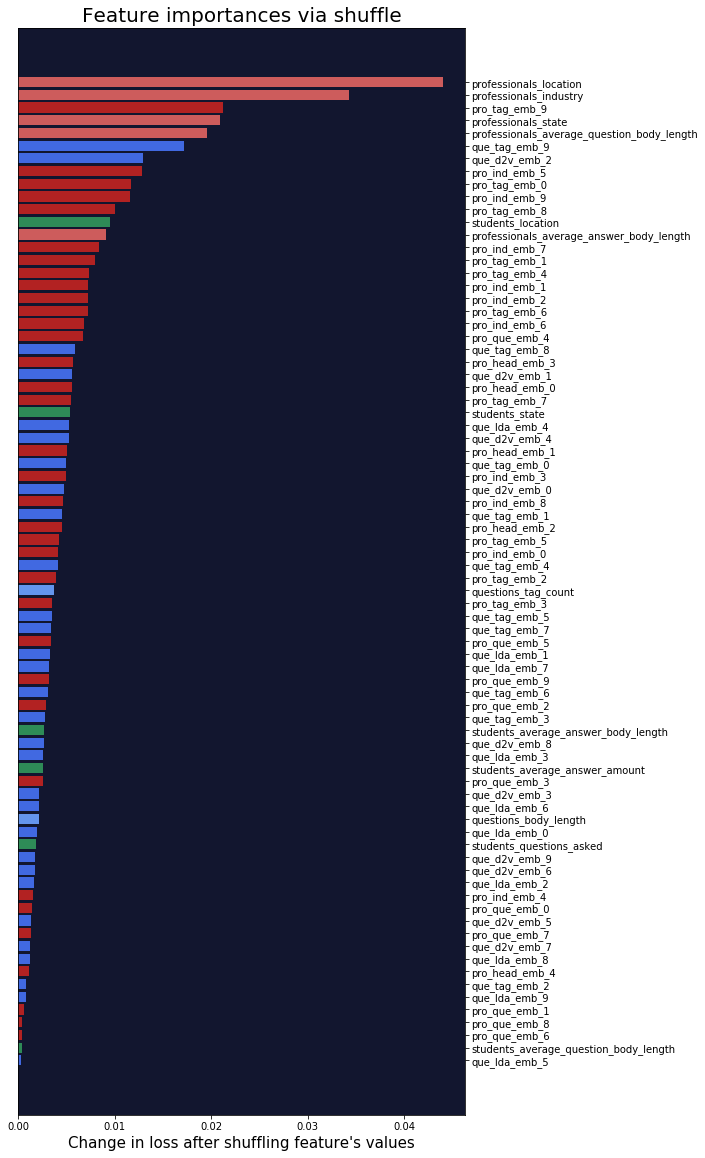

In [49]:
bg = BatchGenerator(que_data, stu_data, pro_data, 1024, pos_pairs, pos_pairs, pro_to_date)

fn = {"que": list(stu_data.columns[2:]) + list(que_data.columns[2:]),
      "pro": list(pro_data.columns[2:])}

fi = permutation_importance(model, bg[0][0][0], bg[0][0][1], bg[0][1], fn, n_trials=3)
plot_fi(fi)

In [50]:
def vis_model_emb(layer, names, title):
    emb = layer.get_weights()[0]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(emb[:, 0], emb[:, 1], s=90, c='#69f0ff')
    for i, name in enumerate(names):
        ax.annotate(name, (emb[i, 0], emb[i, 1]), color='w')
    plt.title(title)

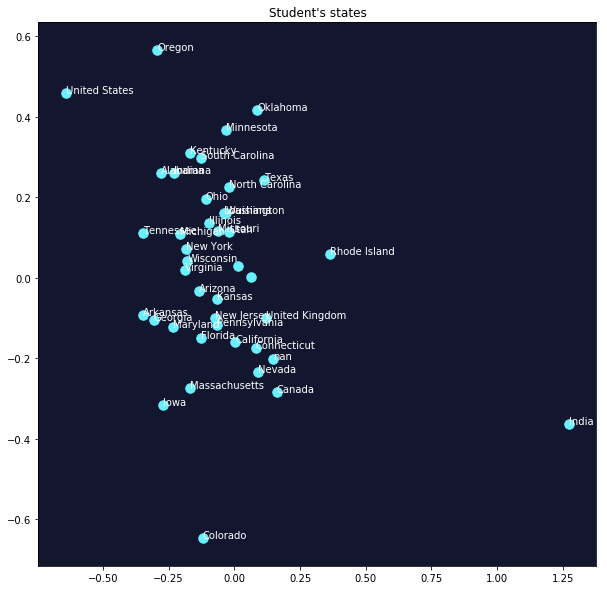

In [51]:
vis_model_emb(model.get_layer('embedding_2'), stu_proc.pp['students_state'].classes_, "Student's states")

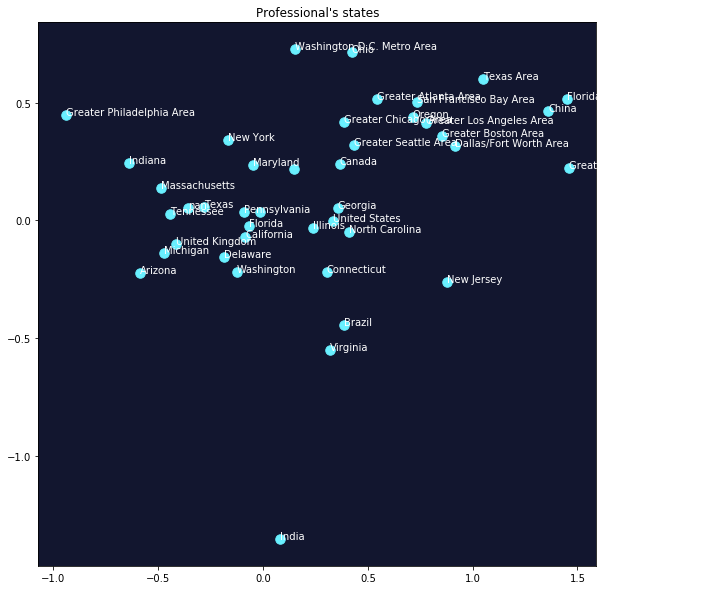

In [52]:
vis_model_emb(model.get_layer('embedding_5'), pro_proc.pp['professionals_state'].classes_, "Professional's states")

### Test <a id="nna_test"></a>

In [53]:
nonneg_pairs = pos_pairs

pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] >= SPLIT_DATE].itertuples(index=False, name=None))
nonneg_pairs += pos_pairs


que_proc = QueProc(tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model)
que_data = que_proc.transform(questions, tag_que)

stu_proc = StuProc()
stu_data = stu_proc.transform(students, questions, answers)

pro_proc = ProProc(tag_embs, ind_embs, head_d2v, ques_d2v)
pro_data = pro_proc.transform(professionals, questions, answers, tag_pro)

bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, nonneg_pairs, pro_to_date)

In [54]:
loss, acc = model.evaluate_generator(bg)
print(f'Loss: {loss}, accuracy: {acc}')

Loss: 0.5178300394461706, accuracy: 0.7566105769230769


## Recommendation engine <a id="re"></a>

In [55]:
from sklearn.neighbors import KDTree

class Predictor:


    def __init__(self, model: keras.Model, que_data: pd.DataFrame, stu_data: pd.DataFrame, pro_data: pd.DataFrame,
                 que_proc: QueProc, pro_proc: ProProc, que_to_stu: dict, pos_pairs: list):

        self.model = model

        self.que_dict = {row.values[0]: row.values[2:] for i, row in que_data.iterrows()}
        self.stu_dict = {stu: group.values[-1, 2:] for stu, group in stu_data.groupby('students_id')}
        self.pro_dict = {pro: group.values[-1, 2:] for pro, group in pro_data.groupby('professionals_id')}
        
        self.entity_to_paired = dict()
        
        for que, stu, pro, time in pos_pairs:
            if que not in self.entity_to_paired:
                self.entity_to_paired[que] = {pro}
            else:
                self.entity_to_paired[que].add(pro)
                
            if pro not in self.entity_to_paired:
                self.entity_to_paired[pro] = {que}
            else:
                self.entity_to_paired[pro].add(que)


        que_feat, que_ids, pro_feat, pro_ids = [], [], [], []

        for que in self.que_dict.keys():
            cur_stu = que_to_stu[que]
            if cur_stu in self.stu_dict:
                # actual question's features are both question and student's features
                que_feat.append(np.hstack([self.stu_dict[cur_stu], self.que_dict[que]]))
                que_ids.append(que)

        for pro in self.pro_dict.keys():
            pro_feat.append(self.pro_dict[pro])
            pro_ids.append(pro)

        self.pro_feat = np.vstack(pro_feat)
        self.pro_ids = np.vstack(pro_ids)
        self.que_feat = np.vstack(que_feat)
        self.que_ids = np.vstack(que_ids)

        self.que_model = model.que_model
        self.pro_model = model.pro_model

        self.que_lat_vecs = self.que_model.predict(self.que_feat)
        self.pro_lat_vecs = self.pro_model.predict(self.pro_feat)

        self.que_tree = KDTree(self.que_lat_vecs)
        self.pro_tree = KDTree(self.pro_lat_vecs)

        self.que_proc = que_proc
        self.pro_proc = pro_proc

    def __get_que_latent(self, que_df: pd.DataFrame, que_tags: pd.DataFrame) -> np.ndarray:

        que_df['questions_date_added'] = pd.to_datetime(que_df['questions_date_added'])

        que_feat = self.que_proc.transform(que_df, que_tags).values[:, 2:]

        stu_feat = np.vstack([self.stu_dict[stu] for stu in que_df['questions_author_id']])
        que_feat = np.hstack([stu_feat, que_feat])

        lat_vecs = self.que_model.predict(que_feat)

        return lat_vecs

    def __get_pro_latent(self, pro_df: pd.DataFrame, que_df: pd.DataFrame, ans_df: pd.DataFrame,
                         pro_tags: pd.DataFrame) -> np.ndarray:
        pro_df['professionals_date_joined'] = pd.to_datetime(pro_df['professionals_date_joined'])
        que_df['questions_date_added'] = pd.to_datetime(que_df['questions_date_added'])
        ans_df['answers_date_added'] = pd.to_datetime(ans_df['answers_date_added'])

        pro_feat = self.pro_proc.transform(pro_df, que_df, ans_df, pro_tags)

        pro_feat = pro_feat.groupby('professionals_id').last().values[:, 1:]

        lat_vecs = self.pro_model.predict(pro_feat)

        return lat_vecs

    def __construct_df(self, ids, sims, scores):
        scores = np.around(scores, 4)
        tuples = []
        for i, cur_id in enumerate(ids):
            for j, sim in enumerate(sims[i]):
                if sim[0] not in self.entity_to_paired.get(cur_id, {}):
                    tuples.append((cur_id, sim[0], scores[i, j]))
        score_df = pd.DataFrame(tuples, columns=['id', 'match_id', 'match_score'])
        return score_df

    def __get_ques_by_latent(self, ids: np.ndarray, lat_vecs: np.ndarray, top: int) -> pd.DataFrame:
        dists, ques = self.que_tree.query(lat_vecs, k=top)
        ques = self.que_ids[ques]
        scores = np.exp(-dists)
        return self.__construct_df(ids, ques, scores)

    def __get_pros_by_latent(self, ids: np.ndarray, lat_vecs: np.ndarray, top: int) -> pd.DataFrame:
        dists, pros = self.pro_tree.query(lat_vecs, k=top)
        pros = self.pro_ids[pros]
        scores = np.exp(-dists)
        return self.__construct_df(ids, pros, scores)

    def find_pros_by_que(self, que_df: pd.DataFrame, que_tags: pd.DataFrame, top: int = 10) -> pd.DataFrame:

        lat_vecs = self.__get_que_latent(que_df, que_tags)
        return self.__get_pros_by_latent(que_df['questions_id'].values, lat_vecs, top)

    def find_ques_by_que(self, que_df: pd.DataFrame, que_tags: pd.DataFrame, top: int = 10) -> pd.DataFrame:

        lat_vecs = self.__get_que_latent(que_df, que_tags)
        return self.__get_ques_by_latent(que_df['questions_id'].values, lat_vecs, top)

    def find_ques_by_pro(self, pro_df: pd.DataFrame, que_df: pd.DataFrame, ans_df: pd.DataFrame,
                         pro_tags: pd.DataFrame, top: int = 10) -> pd.DataFrame:

        lat_vecs = self.__get_pro_latent(pro_df, que_df, ans_df, pro_tags)
        return self.__get_ques_by_latent(pro_df['professionals_id'].values, lat_vecs, top)

    def find_pros_by_pro(self, pro_df: pd.DataFrame, que_df: pd.DataFrame, ans_df: pd.DataFrame,
                         pro_tags: pd.DataFrame, top: int = 10) -> pd.DataFrame:

        lat_vecs = self.__get_pro_latent(pro_df, que_df, ans_df, pro_tags)
        return self.__get_pros_by_latent(pro_df['professionals_id'].values, lat_vecs, top)

In [56]:
class Formatter:

    def __init__(self, data_path: str):
        pro = pd.read_csv(data_path + 'professionals.csv')
        que = pd.read_csv(data_path + 'questions.csv')

        tags = pd.read_csv(data_path + 'tags.csv')
        tag_users = pd.read_csv(data_path + 'tag_users.csv')
        tag_que = pd.read_csv(data_path + 'tag_questions.csv')

        tag_merged = tags.merge(tag_users, left_on='tags_tag_id', right_on='tag_users_tag_id')
        tags_grouped = tag_merged.groupby('tag_users_user_id').agg(lambda x: ' '.join(x))[['tags_tag_name']]
        self.pro = pro.merge(tags_grouped, left_on='professionals_id', right_index=True, how='left')

        tag_merged = tags.merge(tag_que, left_on='tags_tag_id', right_on='tag_questions_tag_id')
        tags_grouped = tag_merged.groupby('tag_questions_question_id').agg(lambda x: ' '.join(x))[['tags_tag_name']]
        self.que = que.merge(tags_grouped, left_on='questions_id', right_index=True, how='left')

    def get_que(self, scores: pd.DataFrame) -> pd.DataFrame:

        return self.que.merge(scores, left_on='questions_id', right_on='match_id').sort_values('match_score',
                                                                                               ascending=False)

    def get_pro(self, scores: pd.DataFrame) -> pd.DataFrame:

        return self.pro.merge(scores, left_on='professionals_id', right_on='match_id').sort_values('match_score',
                                                                                                   ascending=False)

    @staticmethod
    def __convert_tuples(ids, tags):
        tuples = []
        for i, tgs in enumerate(tags):
            que = ids[i]
            for tag in tgs.split(' '):
                tuples.append((que, tag))
        return tuples

    @staticmethod
    def convert_que_dict(que_dict: dict) -> (pd.DataFrame, pd.DataFrame):

        que_df = pd.DataFrame.from_dict(que_dict)

        tuples = Formatter.__convert_tuples(que_df['questions_id'].values, que_df['questions_tags'].values)

        que_tags = pd.DataFrame(tuples, columns=['tag_questions_question_id', 'tags_tag_name'])
        que_df.drop(columns='questions_tags', inplace=True)

        que_tags['tags_tag_name'] = que_tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))
        que_df['questions_title'] = que_df['questions_title'].apply(tp.process)
        que_df['questions_body'] = que_df['questions_body'].apply(tp.process)
        que_df['questions_whole'] = que_df['questions_title'] + ' ' + que_df['questions_body']
        
        return que_df, que_tags

    @staticmethod
    def convert_pro_dict(pro_dict: dict) -> (pd.DataFrame, pd.DataFrame):

        pro_df = pd.DataFrame.from_dict(pro_dict)
        pros = pro_df['professionals_id'].values

        tuples = Formatter.__convert_tuples(pro_df['professionals_id'].values,
                                            pro_df['professionals_subscribed_tags'].values)

        pro_tags = pd.DataFrame(tuples, columns=['tag_users_user_id', 'tags_tag_name'])
        pro_df.drop(columns='professionals_subscribed_tags', inplace=True)
        
        pro_tags['tags_tag_name'] = pro_tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))
        pro_df['professionals_headline'] = pro_df['professionals_headline'].apply(tp.process)
        pro_df['professionals_industry'] = pro_df['professionals_industry'].apply(tp.process)

        return pro_df, pro_tags

In [57]:
que_to_stu = {row['questions_id']: row['questions_author_id'] for i, row in questions.iterrows()}

In [58]:
predictor = Predictor(model, que_data, stu_data, pro_data, que_proc, pro_proc, que_to_stu, nonneg_pairs)

In [59]:
formatter = Formatter(DATA_PATH)

In [60]:
que_sample_dict = {
    'questions_id': ['0'],
    'questions_author_id': ['02946e467bab4fd794e42f9670cb4279'],
    'questions_date_added': ['2017-07-29 13:30:50 UTC+0000'],
    'questions_title': ['I want to study law but not sure what subjects need to be taken,so need some advice on that.'],
    'questions_body': ['#law-practice #lawyer #career-details'],
    'questions_tags': ['lawyer law-practice career-details']
}

In [61]:
que_sample_df, que_sample_tags = formatter.convert_que_dict(que_sample_dict)

In [62]:
tmp = predictor.find_ques_by_que(que_sample_df, que_sample_tags)
formatter.get_que(tmp)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
0,d6ee6363b5f7486eb362bc615630fda8,02946e467bab4fd794e42f9670cb4279,2017-07-29 13:30:50 UTC+0000,I want to study law but not sure what subjects...,#law-practice #lawyer #career-details,lawyer law-practice career-details,0,d6ee6363b5f7486eb362bc615630fda8,1.0000
1,24c90ef5d22442238e038db8e7e6c6ac,40425a2864bf4e449c8794e8fe744745,2014-03-05 22:37:34 UTC+0000,How long does it take to become a lawyer?,I am in the 11th grade. I am interested in law...,law lawyer lawyers,0,24c90ef5d22442238e038db8e7e6c6ac,0.8887
6,d41a831338064f24a9bb01fa46576d1b,0af9b01dac2f440aa88dc7187f0e0d41,2018-01-17 14:36:18 UTC+0000,Is it hard to maintain your moral convictions ...,I want to become a lawyer in the criminal pros...,law lawyer,0,d41a831338064f24a9bb01fa46576d1b,0.8767
3,38cd297815d845bfa8d624867969a2c9,74ae66cce4b34687b96a8d94367651e3,2018-03-30 18:31:44 UTC+0000,How does a woman make a change in the legal s...,#law #law-practice #women-in-law,law law-practice women-in-law,0,38cd297815d845bfa8d624867969a2c9,0.8664
5,c204312032a44673b555c69b71748288,e0aa51151171467c8c189fc91c16b98f,2016-05-13 23:58:14 UTC+0000,What careers are available for a political sci...,Im about to start college in the fall and i ha...,lawyer government political-science judges,0,c204312032a44673b555c69b71748288,0.8596
7,36a2f091a7194f9ab73d86c0f39c43b5,9cbb6d2b032c4879a8d27c06d814e158,2015-10-27 00:23:13 UTC+0000,what are the basics of being a lawyer,"Hi,\r\nI am in 6th grade and I want to know wh...",law lawyer,0,36a2f091a7194f9ab73d86c0f39c43b5,0.8581
9,529585ceeefa4d34b06e0574e371dc85,f31b525a7af042dd9f9499d8e2048f2e,2015-03-08 02:14:22 UTC+0000,What are some good things to know if you are t...,I just want to know the basic things I need to...,lawyers,0,529585ceeefa4d34b06e0574e371dc85,0.8534
8,983a8e2a289e4eea934803a5ac75223c,bf8f55bd5b194e279dc466405709f78f,2017-09-29 18:05:27 UTC+0000,Legal Consultant or Law Professor?,"Hi Guys,\n\nI'm a college Freshman trying to d...",law,0,983a8e2a289e4eea934803a5ac75223c,0.8533
2,729e05bbf7154a78bfa8301f35bf8376,d1d32ffaca5d4218b20fbcbeaaec1417,2016-04-11 19:57:44 UTC+0000,Does being a lawyer earn you good pay?,Will being a lawyer earn you good pay?I am ask...,lawyer attorney barrister,0,729e05bbf7154a78bfa8301f35bf8376,0.8467
4,f36b2af39c2d4a1c848c916453925312,6bc1fb0f499f46878fc6802bab1dc70e,2016-05-03 23:11:34 UTC+0000,want to be a lawyer,what is the goal to be a lawyer and why it is ...,lawyer,0,f36b2af39c2d4a1c848c916453925312,0.8467


In [63]:
tmp = predictor.find_pros_by_que(que_sample_df, que_sample_tags)
formatter.get_pro(tmp)

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,tags_tag_name,id,match_id,match_score
6,6bd4a043f3314f5fb9da0384ca111787,Greater New York City Area,Philanthropy,Administrative Intern at The Jewish Federation...,2018-05-22 19:17:32 UTC+0000,philanthropy,0,6bd4a043f3314f5fb9da0384ca111787,0.9004
3,66a2209ba12c4f3d838783c93f08e1d8,"Grapevine, Texas",Legal Services,Enforcing Consumer Protection Laws,2017-02-02 02:48:53 UTC+0000,legal-services,0,66a2209ba12c4f3d838783c93f08e1d8,0.8840
0,a32dba0c1a2d432da37e44f9726cf307,United States,Legal Services,"Attorney, Mediator, Diversity & EEO Professional",2015-11-15 07:08:25 UTC+0000,law-services,0,a32dba0c1a2d432da37e44f9726cf307,0.8759
1,fc0a5be764a443bf919728e05b822fde,"California, California",Law Practice,Legal Counsel,2015-12-04 12:46:49 UTC+0000,NaN,0,fc0a5be764a443bf919728e05b822fde,0.8758
5,4a7e2e0913684eabb77144e7bc00067d,"Wenonah, New Jersey",Law Practice,Hannon Law Office,2017-09-30 19:00:32 UTC+0000,law-school law-practice civil-liigation,0,4a7e2e0913684eabb77144e7bc00067d,0.8755
7,24851508301d441191600f0cb763332e,United States,Legal Services,NCCU Law Graduate,2018-10-04 13:44:24 UTC+0000,legal-services,0,24851508301d441191600f0cb763332e,0.8706
2,e87643e0c06048d19410088222e3f14c,"Los Angeles, California",Legal Services,Attorney at Law,2016-03-03 18:41:30 UTC+0000,law-services,0,e87643e0c06048d19410088222e3f14c,0.8656
4,a4cf9fceb477485fa25879ee01af9976,"Houston, Texas",Legal Services,"Associate Attorney at Cook Legal Group, LLLP",2017-02-07 23:28:58 UTC+0000,legal-services,0,a4cf9fceb477485fa25879ee01af9976,0.8621
8,148eb81cb8a54dd99393e694349b44a0,"Dallas, Texas",Law Practice,"Attorney at Smith Downs Group, PLLC",2018-11-20 00:21:44 UTC+0000,law-practice #lawyer,0,148eb81cb8a54dd99393e694349b44a0,0.8615
9,1919a81de8f04b089d8fbf3cd7316cc5,United States,Legal Services,Student at San Francisco State University,2019-01-23 21:18:28 UTC+0000,legal-services,0,1919a81de8f04b089d8fbf3cd7316cc5,0.8580


#### By professional

In [64]:
pro_sample_dict = {
    'professionals_id': ['eae09bbc30e34f008e10d5aa70d521b2'],
    'professionals_location': ['Narberth, Pennsylvania'],
    'professionals_industry': ['Veterinary'],
    'professionals_headline': ['Veterinarian'],
    'professionals_date_joined': ['2017-09-26 18:10:23 UTC+0000'],
    'professionals_subscribed_tags': ['veterinary #animal']
}

In [65]:
pro_sample_df, pro_sample_tags = formatter.convert_pro_dict(pro_sample_dict)

In [66]:
tmp = predictor.find_ques_by_pro(pro_sample_df, questions, answers, pro_sample_tags)
formatter.get_que(tmp)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
5,45a4374518fa45a48bc5cabe8e57ca7c,68603fada2a84ddc8b32551a3db21f0d,2017-09-01 07:27:09 UTC+0000,I want to become a Veterinarian but i don't kn...,because I'm not sure so just for clarification...,veterinarian veterinary veterinary-medicine ve...,eae09bbc30e34f008e10d5aa70d521b2,45a4374518fa45a48bc5cabe8e57ca7c,0.8228
7,94a4257e41674145ad0940e39279f2c9,5a858ab44eea4ee5a370e797fd5293c3,2016-05-26 00:21:12 UTC+0000,How much commitment should be put into becomin...,I love animals and would die for them! But I w...,veterinarian veterinary-medicine,eae09bbc30e34f008e10d5aa70d521b2,94a4257e41674145ad0940e39279f2c9,0.7772
3,a57b1ccf32444a238c09845d255fecb1,e2a59cd88e6f4d559c3418db5263dc36,2016-05-04 22:53:20 UTC+0000,What are the difficulties of being a veterinar...,I'm thinking about being a veterinarian and I ...,biology health veterinarian veterinary veterin...,eae09bbc30e34f008e10d5aa70d521b2,a57b1ccf32444a238c09845d255fecb1,0.7769
2,470757477f444225bba61f110ff488b9,d580b00797624b65a45c56f378be9638,2016-05-24 01:46:28 UTC+0000,What are some classes I should take for becomi...,I am asking this cause I am interested in beco...,medicine science veterinarian veterinary-medic...,eae09bbc30e34f008e10d5aa70d521b2,470757477f444225bba61f110ff488b9,0.7763
9,36ec2fb6a1b4423d88b24bdd5657b7c2,d1c3af9aaf4e4644831652f3bb1becd0,2014-12-12 15:33:37 UTC+0000,To become a veterinarian what classes should i...,"i would like to become a veterinarian, and wou...",doctor veterinarian veterinary-medicine animal...,eae09bbc30e34f008e10d5aa70d521b2,36ec2fb6a1b4423d88b24bdd5657b7c2,0.7606
1,262ca652963743d089fc5dcc398255ae,f74ab5a3b2ce448b90b1e2cb64892b55,2016-05-18 01:32:28 UTC+0000,What does it takes to be a Medical practitioner,I have always wanted a career in the field of ...,doctor veterinary optometrist,eae09bbc30e34f008e10d5aa70d521b2,262ca652963743d089fc5dcc398255ae,0.7584
8,2f49238bfe144d7f97feb97b76a5d9db,d1c3af9aaf4e4644831652f3bb1becd0,2014-12-12 15:35:27 UTC+0000,To become a veterinarian what high school clas...,"i would like to become a veterinarian, and wou...",doctor veterinarian veterinary-medicine animal...,eae09bbc30e34f008e10d5aa70d521b2,2f49238bfe144d7f97feb97b76a5d9db,0.7576
4,6e8bd4872ccd47ea917c45cf09ed02f3,d35295645bc14df9bd9b8bc8710e0b8d,2016-09-22 18:31:38 UTC+0000,Do you have to work with all kinds of animals ...,I just want to know if I will also have to wor...,animal-health,eae09bbc30e34f008e10d5aa70d521b2,6e8bd4872ccd47ea917c45cf09ed02f3,0.7553
6,6341a408fbab4a2f831229020aa0d0fd,d35295645bc14df9bd9b8bc8710e0b8d,2016-09-20 18:56:26 UTC+0000,What are some requirements to become a veterin...,I would like to know what it takes to become a...,animal-health,eae09bbc30e34f008e10d5aa70d521b2,6341a408fbab4a2f831229020aa0d0fd,0.7498
0,2fd3df4c1c5044a49c5ab62f2a8970ec,adb24f0777a343c18d7ab409471e6c41,2018-03-13 00:39:56 UTC+0000,How can I specialize as a veterinarian?,I am a high school senior who has always wante...,veterinarian veterinary veterinary-medicine an...,eae09bbc30e34f008e10d5aa70d521b2,2fd3df4c1c5044a49c5ab62f2a8970ec,0.7459


##### Similar professionals


In [67]:
tmp = predictor.find_pros_by_pro(pro_sample_df, questions, answers, pro_sample_tags)
formatter.get_pro(tmp)

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,tags_tag_name,id,match_id,match_score
3,eae09bbc30e34f008e10d5aa70d521b2,"Narberth, Pennsylvania",Veterinary,Veterinarian,2017-09-26 18:10:23 UTC+0000,veterinary #animal,eae09bbc30e34f008e10d5aa70d521b2,eae09bbc30e34f008e10d5aa70d521b2,1.0000
8,cd96261f57364dc1ada1a69118e852a6,Greater Philadelphia Area,Veterinary,veterinarian at Garden State Animal Hospital,2018-03-21 12:22:23 UTC+0000,veterinary,eae09bbc30e34f008e10d5aa70d521b2,cd96261f57364dc1ada1a69118e852a6,0.8786
0,16b56135c6ad4aea80f2d67c980fdd82,"Los Angeles, California",Veterinary,"Associate Veterinarian, General Practice and E...",2016-01-14 01:48:29 UTC+0000,veterinary,eae09bbc30e34f008e10d5aa70d521b2,16b56135c6ad4aea80f2d67c980fdd82,0.8634
5,a0b49a98c003432383bb096ecb26e6b2,"Tulsa, Oklahoma Area",Veterinary,Registered Veterinary Technician at Oklahoma V...,2017-12-15 19:19:46 UTC+0000,veterinary animals animal-health veterinary-te...,eae09bbc30e34f008e10d5aa70d521b2,a0b49a98c003432383bb096ecb26e6b2,0.8549
1,cb68900031664fb68d4ce41d4013747d,"Austin, Texas",Veterinary,Veterinarian at Westgate Pet and Bird Hospital,2017-01-25 19:08:38 UTC+0000,veterinary,eae09bbc30e34f008e10d5aa70d521b2,cb68900031664fb68d4ce41d4013747d,0.8444
9,0d1cf536265f4ba9a5804d9034515ed1,Greater Philadelphia Area,Veterinary,Complimentary/Alternative Veterinarian at Mead...,2018-12-26 02:32:21 UTC+0000,veterinary #animalhealthcare,eae09bbc30e34f008e10d5aa70d521b2,0d1cf536265f4ba9a5804d9034515ed1,0.8427
4,2f2163f3f5b940638bd5681d19f06ad5,NaN,Veterinary,Veterinarian at Four Paws Veterinary Services,2017-12-05 02:49:05 UTC+0000,veterinary,eae09bbc30e34f008e10d5aa70d521b2,2f2163f3f5b940638bd5681d19f06ad5,0.8360
6,30a510b81eed40d08fc5e5fefdd87226,"San Antonio, Texas Area",Veterinary,Associate Veterinarian at Northern Oaks Bird &...,2018-01-25 02:18:05 UTC+0000,veterinary,eae09bbc30e34f008e10d5aa70d521b2,30a510b81eed40d08fc5e5fefdd87226,0.8255
7,4d7399b5e1e94ae2ade8c24b59f1f562,"Los Angeles, California",Veterinary,"Medical Director, Emergency Veterinarian VCA-AVCC",2018-02-26 22:52:40 UTC+0000,veterinary animal-health pre-veterinary-medicine,eae09bbc30e34f008e10d5aa70d521b2,4d7399b5e1e94ae2ade8c24b59f1f562,0.8198
2,b6c311c84a514040b82fa0a2bee67e90,"Austin, Texas Area",Veterinary,Student at College of Biblical Studies - Houston,2017-07-25 22:06:56 UTC+0000,veterinary,eae09bbc30e34f008e10d5aa70d521b2,b6c311c84a514040b82fa0a2bee67e90,0.8112


In [68]:
def activity_filter(ans_dates: np.ndarray, cur_date: np.datetime64, tail_prob: np.double=0.05,
                    min_days: np.double=0.5, max_days: np.double=15):

    realiz = (cur_date - ans_dates[-1]) / np.timedelta64(1, 'D')

    if ans_dates.size >= 3:
        int_lens = np.diff(ans_dates) / np.timedelta64(1, 'D')
    else:

        return True if (realiz > min_days and realiz < max_days) else False
 
    int_lens = np.clip(int_lens, min_days, max_days)
    
    df = int_lens.size - 1
    loc = int_lens.mean()
    scale = max(int_lens.std(ddof=1), min_days)

    prob = t.cdf(realiz, df=df, loc=loc, scale=scale)    
    if prob > 0.5:
        prob = 1 - prob
    
    if (prob > tail_prob / 2 or realiz < max_days) and realiz > min_days:
        return True
    return False

In [69]:
pro_answer_dates = pro_data.set_index('professionals_id')['professionals_time']
pro_answer_dates.fillna(pro_to_date, inplace=True)

In [70]:
que_dict = {
    'questions_id': ['6351c23f2e144b359c3301d40b3d81ef'],
    'questions_author_id': ['4627ecfaf1814d2e8935ed3e3cd4b88b'],
    'questions_date_added': ['2018-08-14 20:10:09 UTC+0000'],
    'questions_title': ['What major is best for an aspiring Occupational Therapist?'],
    'questions_body': ['#majors #occupationaltherapist'],
    'questions_tags': ['majors occupationaltherapist']
}

In [71]:
que_df, que_tags = formatter.convert_que_dict(que_dict)

Get top n professionals based on Content Model Predictor

In [72]:
top_n = 28000
current_date = np.datetime64('2018-08-16 00:00:00')

In [73]:
pred_pros = predictor.find_pros_by_que(que_df, que_tags, top=top_n)

Select only professionals who are estimated to be active on current date

In [74]:
active_pros = []

for pro in pred_pros['match_id'].iloc[:top_n]:
    try:
        answer_dates = pro_answer_dates.loc[pro].values
    except:
        continue
    
    answer_dates = answer_dates[answer_dates < current_date]
    
    if answer_dates.size > 0 and activity_filter(answer_dates, current_date):
        active_pros.append(pro)

active_pros = np.array(active_pros)

In [75]:
print('Amount of active professionals among top {} is {}.'.format(top_n, len(active_pros)))

Amount of active professionals among top 28000 is 394.


In [76]:
pred_pros.head(10)

,id,match_id,match_score
0,6351c23f2e144b359c3301d40b3d81ef,7e6182d10d044bccbc73ddec0e842746,0.9191
1,6351c23f2e144b359c3301d40b3d81ef,c6af1d7cd93147d59836ae5fa30f94da,0.9102
2,6351c23f2e144b359c3301d40b3d81ef,b3f8f6b23dbe4211b153c4d873cdd39f,0.9101
3,6351c23f2e144b359c3301d40b3d81ef,11b180fdc3f24f9bbc861960e59a5a44,0.9054
4,6351c23f2e144b359c3301d40b3d81ef,3037ac6cca634cc4aa3fa3fbe65b726b,0.9034
5,6351c23f2e144b359c3301d40b3d81ef,ca4552a14df84cd1ba8f71cb33f271ab,0.8960
6,6351c23f2e144b359c3301d40b3d81ef,78198cf64144468595f6a771ae2b38d5,0.8930
7,6351c23f2e144b359c3301d40b3d81ef,b090a5122b974ff2a05699f324e1e126,0.8895
8,6351c23f2e144b359c3301d40b3d81ef,da923682a35946c182f341e99e35625c,0.8865
9,6351c23f2e144b359c3301d40b3d81ef,f1409e4f8da747c9954aca07622aef8b,0.8849


In [77]:
active_pros = pred_pros.merge(pd.DataFrame({'match_id': active_pros}), on='match_id')
active_pros.head(10)

,id,match_id,match_score
0,6351c23f2e144b359c3301d40b3d81ef,7e721be7613246dd9f1aee1fb31271b2,0.7646
1,6351c23f2e144b359c3301d40b3d81ef,14f13a22a3bf40dfbbd97786f99600c3,0.7551
2,6351c23f2e144b359c3301d40b3d81ef,1c206d320f8247b08f4eac3c7bc34950,0.7471
3,6351c23f2e144b359c3301d40b3d81ef,8f72dfab7ed048d19e744ff6db02f9aa,0.7395
4,6351c23f2e144b359c3301d40b3d81ef,5bc2db4d58584f95bdba30ed2c21d573,0.7323
5,6351c23f2e144b359c3301d40b3d81ef,79728ddb941049c89fb7f64028f9bd41,0.7272
6,6351c23f2e144b359c3301d40b3d81ef,6ad2a6c6a00f4080a54f0df04c0925dc,0.7268
7,6351c23f2e144b359c3301d40b3d81ef,b3fa49b12d804ca4946fc55ca4a4d82a,0.7226
8,6351c23f2e144b359c3301d40b3d81ef,02fd718863804d348f3afa7a569070c4,0.7173
9,6351c23f2e144b359c3301d40b3d81ef,cb7141606c7b4a00ab42547b55091978,0.7015


In [78]:
def spam_filter(question_id: str, email_ques: np.ndarray, previous_email_date: np.datetime64,
                   cur_date: np.datetime64, min_days: np.double=0.5):

    if (cur_date - previous_email_date) / np.timedelta64(1, 'D') < min_days or question_id in email_ques:
        return False
    return True

In [79]:
def email_filter(que: str, email_ques: np.ndarray, email_dates: np.ndarray,
                 ans_ques: np.ndarray, ans_dates: np.ndarray,
                 cur_date: np.datetime64, offset_days: np.double,
                 min_days: np.double=0.5, max_days: np.double=7, thresh: np.double=0.1):
 
    if not spam_filter(que, email_ques, email_dates.max(), cur_date, min_days):
        return False
    
    ques, email_idx, ans_idx = np.intersect1d(email_ques, ans_ques, assume_unique=False, return_indices=True)
    email_dates = email_dates[email_idx]
    ans_dates = ans_dates[ans_idx]
    
    if ques.size < 2:
        return False
    
    email_frac = ques.size / email_ques.size
    
    
    int_lens = (ans_dates - email_dates) / np.timedelta64(1, 'D') 
    int_lens = np.clip(int_lens, min_days, max_days)
 
    df = int_lens.size - 1
    loc = int_lens.mean()
    scale = max(int_lens.std(ddof=1), min_days)
    
    ans_prob = t.cdf(offset_days, df=df, loc=loc, scale=scale)
    
    score = 2 * email_frac * ans_prob / (email_frac + ans_prob)
    
    return score > thresh

In [80]:
test_question_id = '6351c23f2e144b359c3301d40b3d81ef'

In [81]:
emailed_pros = []


for pro in active_pros['match_id']:
    try:
        email_ques = pro_email_ques['questions_id'].loc[pro].values
        email_dates = pro_email_ques['emails_date_sent'].loc[pro].values
        ans_ques = pro_answers['questions_id'].loc[pro].values
        ans_dates = pro_answers['answers_date_added'].loc[pro].values
    except:
        continue

    email_ques, email_dates = email_ques[email_dates < current_date], email_dates[email_dates < current_date]
    ans_ques, ans_dates = ans_ques[ans_dates < current_date], ans_dates[ans_dates < current_date]

    if email_ques.size == 0 or ans_ques.size == 0:
        continue

    if email_filter(test_question_id, email_ques, email_dates, ans_ques, ans_dates, current_date, 1):
        emailed_pros.append(pro)

emailed_pros = np.array(emailed_pros)

In [82]:
emailed_pros = active_pros.merge(pd.DataFrame({'match_id': emailed_pros}), on='match_id')
emailed_pros

,id,match_id,match_score
0,6351c23f2e144b359c3301d40b3d81ef,7e721be7613246dd9f1aee1fb31271b2,0.7646
1,6351c23f2e144b359c3301d40b3d81ef,24fac8940aff427c848b2a59265c1204,0.5747
2,6351c23f2e144b359c3301d40b3d81ef,b342ccddf46547bb924181e958432391,0.5287
3,6351c23f2e144b359c3301d40b3d81ef,13b55ed4834e4814bb33a4c87001063d,0.4407
4,6351c23f2e144b359c3301d40b3d81ef,c8ffe6358764451982263916bd7fac79,0.4350
5,6351c23f2e144b359c3301d40b3d81ef,0334dfd55c574601ba8e56b4c6e2e4f0,0.4256
6,6351c23f2e144b359c3301d40b3d81ef,a1006e6a58a0447592e2435caa230f78,0.3892
7,6351c23f2e144b359c3301d40b3d81ef,c1bda2764ee642b3859b1ca6839fa16c,0.2698
8,6351c23f2e144b359c3301d40b3d81ef,c3b4e11154f74a858779be7ba9b6f00c,0.2564
9,6351c23f2e144b359c3301d40b3d81ef,89ffc7c3266344b68c2dbce832d102f6,0.2490


In [83]:
def send_quesionts_to_professional(pro_sample_dict, pro_answer_dates, questions,
                                   answers, pro_email_ques, current_date=np.datetime64('now'), 
                                   top_content=20, min_days=7):
    eps_1 = 0.01
    eps_2 = 0.5
    eps_3 = 0.3
    
   
    pro_sample_df, pro_sample_tags = Formatter.convert_pro_dict(pro_sample_dict)
    tmp = predictor.find_ques_by_pro(pro_sample_df, questions, answers, pro_sample_tags, top=top_content)
    content_result = formatter.get_que(tmp)
    que_ids = content_result['questions_id'].values
    

    pro_id = pro_sample_df['professionals_id'].iloc[0]
    answer_dates = pro_answer_dates.loc[pro_id].values
    

    is_active = activity_filter(answer_dates, current_date)
    
   
    try:
        email_ques = pro_email_ques['questions_id'].loc[pro_id].values
        email_dates = pro_email_ques['emails_date_sent'].loc[pro_id].values

        email_ques, email_dates = email_ques[email_dates < current_date], email_dates[email_dates < current_date]
    except:
        email_ques = []
        email_dates = []

    if not email_ques:
        mask = [True] * len(que_ids)
    else:
        mask = []
        for que_id in que_ids:
            mask.append(spam_filter(que_id, email_ques, email_dates.max(), cur_date, min_days=min_days))
            
    mask = np.array(mask)
    passed_questions = que_ids[mask]
    spam_questions = que_ids[~mask]
    
    explore_questions = []
    
    if is_active:
        if passed_questions.size > 0:
            for sq in spam_questions:
                if np.random.rand() < eps_1:
                    explore_questions.append(qs)
    else:
        if passed_questions.size > 0:
            e_cond = eps_2
        else:
            e_cond = eps_3
    
        for sq in spam_questions:
            if np.random.rand() < e_cond:
                explore_questions.append(qs)
            
    final_q_ids = np.append(passed_questions, explore_questions)       
    final_df = content_result[content_result['questions_id'].isin(final_q_ids)]
    
    return final_df

In [84]:
pro_sample_dict = {
    'professionals_id': ['eae09bbc30e34f008e10d5aa70d521b2'],
    'professionals_location': ['Narberth, Pennsylvania'],
    'professionals_industry': ['Veterinary'],
    'professionals_headline': ['Veterinarian'],
    'professionals_date_joined': ['2017-09-26 18:10:23 UTC+0000'],
    'professionals_subscribed_tags': ['veterinary #animal']
}

In [85]:
send_quesionts_to_professional(
    pro_sample_dict,
    pro_answer_dates,
    questions,
    answers,
    pro_email_ques,
    current_date=np.datetime64('2019-01-05')
)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
15,45a4374518fa45a48bc5cabe8e57ca7c,68603fada2a84ddc8b32551a3db21f0d,2017-09-01 07:27:09 UTC+0000,I want to become a Veterinarian but i don't kn...,because I'm not sure so just for clarification...,veterinarian veterinary veterinary-medicine ve...,eae09bbc30e34f008e10d5aa70d521b2,45a4374518fa45a48bc5cabe8e57ca7c,0.8228
17,94a4257e41674145ad0940e39279f2c9,5a858ab44eea4ee5a370e797fd5293c3,2016-05-26 00:21:12 UTC+0000,How much commitment should be put into becomin...,I love animals and would die for them! But I w...,veterinarian veterinary-medicine,eae09bbc30e34f008e10d5aa70d521b2,94a4257e41674145ad0940e39279f2c9,0.7772
11,a57b1ccf32444a238c09845d255fecb1,e2a59cd88e6f4d559c3418db5263dc36,2016-05-04 22:53:20 UTC+0000,What are the difficulties of being a veterinar...,I'm thinking about being a veterinarian and I ...,biology health veterinarian veterinary veterin...,eae09bbc30e34f008e10d5aa70d521b2,a57b1ccf32444a238c09845d255fecb1,0.7769
9,470757477f444225bba61f110ff488b9,d580b00797624b65a45c56f378be9638,2016-05-24 01:46:28 UTC+0000,What are some classes I should take for becomi...,I am asking this cause I am interested in beco...,medicine science veterinarian veterinary-medic...,eae09bbc30e34f008e10d5aa70d521b2,470757477f444225bba61f110ff488b9,0.7763
19,36ec2fb6a1b4423d88b24bdd5657b7c2,d1c3af9aaf4e4644831652f3bb1becd0,2014-12-12 15:33:37 UTC+0000,To become a veterinarian what classes should i...,"i would like to become a veterinarian, and wou...",doctor veterinarian veterinary-medicine animal...,eae09bbc30e34f008e10d5aa70d521b2,36ec2fb6a1b4423d88b24bdd5657b7c2,0.7606
5,262ca652963743d089fc5dcc398255ae,f74ab5a3b2ce448b90b1e2cb64892b55,2016-05-18 01:32:28 UTC+0000,What does it takes to be a Medical practitioner,I have always wanted a career in the field of ...,doctor veterinary optometrist,eae09bbc30e34f008e10d5aa70d521b2,262ca652963743d089fc5dcc398255ae,0.7584
18,2f49238bfe144d7f97feb97b76a5d9db,d1c3af9aaf4e4644831652f3bb1becd0,2014-12-12 15:35:27 UTC+0000,To become a veterinarian what high school clas...,"i would like to become a veterinarian, and wou...",doctor veterinarian veterinary-medicine animal...,eae09bbc30e34f008e10d5aa70d521b2,2f49238bfe144d7f97feb97b76a5d9db,0.7576
13,6e8bd4872ccd47ea917c45cf09ed02f3,d35295645bc14df9bd9b8bc8710e0b8d,2016-09-22 18:31:38 UTC+0000,Do you have to work with all kinds of animals ...,I just want to know if I will also have to wor...,animal-health,eae09bbc30e34f008e10d5aa70d521b2,6e8bd4872ccd47ea917c45cf09ed02f3,0.7553
16,6341a408fbab4a2f831229020aa0d0fd,d35295645bc14df9bd9b8bc8710e0b8d,2016-09-20 18:56:26 UTC+0000,What are some requirements to become a veterin...,I would like to know what it takes to become a...,animal-health,eae09bbc30e34f008e10d5aa70d521b2,6341a408fbab4a2f831229020aa0d0fd,0.7498
0,2fd3df4c1c5044a49c5ab62f2a8970ec,adb24f0777a343c18d7ab409471e6c41,2018-03-13 00:39:56 UTC+0000,How can I specialize as a veterinarian?,I am a high school senior who has always wante...,veterinarian veterinary veterinary-medicine an...,eae09bbc30e34f008e10d5aa70d521b2,2fd3df4c1c5044a49c5ab62f2a8970ec,0.7459


In [86]:
pro_sample_dict = {
    'professionals_id': ['6b659c8487eb495cac6c55104c05cfc8'],
    'professionals_location': ['Greater Seattle Area'],
    'professionals_industry': ['Airlines/Aviation'],
    'professionals_headline': ['Finance Specialist - Business Skills Rotation Program at Boeing'],
    'professionals_date_joined': ['2019-01-02 05:10:24 UTC+0000'],
    'professionals_subscribed_tags': 
    'college business career finance management career-counseling internships entrepreneurship '
    'career-path math leadership communications interviews resume english networking career-development '
    'administration mentoring coaching employment organization skills strategy customer-service '
    'development bussiness start-ups culture community-service growth diversity innovation mental-health-care '
    'airlines/aviation authenicleadership change civic-and-social-organization first-generation-college-students '
    'goals health,-wellness-and-fitness'
}

In [87]:
send_quesionts_to_professional(
    pro_sample_dict,
    pro_answer_dates,
    questions,
    answers,
    pro_email_ques,
    current_date=np.datetime64('2019-01-05')
)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
5,524479e554474053a253054ac64c818f,1492eb3730e943fabd5c874af932ba04,2018-11-27 22:13:59 UTC+0000,what is your daly life like as an aircraft mec...,I am currently in job corps and pursuing a car...,aviation military navy mechanic,6b659c8487eb495cac6c55104c05cfc8,524479e554474053a253054ac64c818f,0.8706
0,faa0618d908743608e71ef311d894ced,c9aea85f9d3846f29b038829ba50ab66,2018-05-01 03:00:49 UTC+0000,what is the goal of a chef?,#because i dont know what are the goal of chef...,because,6b659c8487eb495cac6c55104c05cfc8,faa0618d908743608e71ef311d894ced,0.8653
18,8d0c2f3bdf814905b9bd91bc6cadbfdf,0a8576d9db614ce1b4b3a752f05d5f40,2017-02-24 19:08:07 UTC+0000,What would be a great career plan from someone...,I am trying to figure out a great career plan ...,aviation pilot general-aviation,6b659c8487eb495cac6c55104c05cfc8,8d0c2f3bdf814905b9bd91bc6cadbfdf,0.8585
8,6de54dfaa3a340d595f4f1f0e480a07c,40683e805de84c00b32f2f4a6d60c1da,2016-11-01 20:53:01 UTC+0000,How long does it take to become a nurse? Also ...,I want to be a Nurse when i grow up. #management,management,6b659c8487eb495cac6c55104c05cfc8,6de54dfaa3a340d595f4f1f0e480a07c,0.8422
2,db348875a0584918980f84175167ec20,105ee50a53e84453ac0dfd4a851e7966,2018-01-16 14:53:50 UTC+0000,Is it better to apply to the Air Force Academy...,I am interested in joining the Air Force as a ...,engineering nasa airforceacademy,6b659c8487eb495cac6c55104c05cfc8,db348875a0584918980f84175167ec20,0.8386
7,54a609fb7f074c888a5ed6cd3a52b5f0,a49a19e3593a45c0b3a0c0c60e6c60e3,2018-08-14 15:59:36 UTC+0000,What's the best study material for becoming a ...,#aviation #airline-industry #pilot #air-force ...,aviation airline-industry pilot air-force airp...,6b659c8487eb495cac6c55104c05cfc8,54a609fb7f074c888a5ed6cd3a52b5f0,0.8316
9,aef843e483384384b76ccef2c132a83c,0d5e7c32e8b04f7799a59e08f1c841a1,2018-01-14 08:11:45 UTC+0000,What are some potential difficulties in becomi...,I feel that ATC would be a perfect career for ...,aviation air-traffic-control,6b659c8487eb495cac6c55104c05cfc8,aef843e483384384b76ccef2c132a83c,0.8295
6,7d088c69609d4825ae0eeee624157491,0d5e7c32e8b04f7799a59e08f1c841a1,2018-01-14 08:09:39 UTC+0000,Are there any good colleges for aviation in O'...,"I'm interested in air traffic control, and wou...",college aviation oahu,6b659c8487eb495cac6c55104c05cfc8,7d088c69609d4825ae0eeee624157491,0.8191
14,218d2678a1ec498a9f07dd213e0fcf20,323204bcd4184ca48bf9354f712bf195,2016-05-25 22:38:33 UTC+0000,Would you recommend field experience over offi...,I was recently asked whether I want to go the ...,construction,6b659c8487eb495cac6c55104c05cfc8,218d2678a1ec498a9f07dd213e0fcf20,0.8180
10,97c1b72c179948a2a050a82b6177001d,d5047d3082924f58a3baedea251a385b,2017-02-15 17:28:50 UTC+0000,How many years experiences to be needed in Shi...,24 years old graduated student. Willing to wor...,shipbroking shipping broker brokers,6b659c8487eb495cac6c55104c05cfc8,97c1b72c179948a2a050a82b6177001d,0.8170
